In [81]:
# Se importa la clase BanditEnvs del archivo BanditEnvs.py modificado con los ambientes run_env_4 y run_env_5

# from envs import BanditEnvs
# from BanditEnvs import  *

from BanditEnvs import BanditEnvs

# Se importan otras librerias utiles
import random
import math
import numpy as np
import matplotlib.pyplot as plt
from statistics import *

from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')

# Introducción 

El presente informe presenta la implementación del método de acción de valor (action value Q(ai) ) mediante el método E-greedy así como también las métricas de evaluación del algoritmo para comparar diferentes tasas de aprendizaje $\alpha$ teniendo en cuenta las distribuciones de las acciones del n-bandit creadas en el módulo/clase BanditEnvs (véase script modificado BanditEnvs), donde se añadieron los escenarios 'run_env_4' y 'run_env_5'. El objetivo es encontrar la tasa de aprendizaje $\alpha_n$ adecuada para los escenarios 'run_env_4' y 'run_env_5', teniendo en cuenta las distribuciones de las acciones del n-bandit generadas, las variaciones de la función coseno y los resultados de las métricas de evaluación de los métodos de acción de valor para un problema de n-Bandits con 12 acciones. 

Ambos escenarios tienen distrubución normal con media $\mu = \beta_i + cos(w_0*t)$ y varianza $\sigma=1$, donde $w_0=\pi/100000$ para el escenario run_env_4 y $w_0=\pi/1000$ para el escenario run_env_5. Del mismo modo la variable $\beta_i$ tiene distribución normal con media $\mu=0$ y varianza $\sigma=1$. A partir de la implementación anterior y las gráficas de la función $cos(w_0*t)$ se determinó que el escenario run_env_4 presenta pequeños cambios ya que la función $cos(w_0*t)$ tiene baja frecuencia y el factor de $cos(w_0*t)$ siempre tiende a ser 1 constante por lo que se puede considerar como un caso estacionario, mientras que el escenario run_env_5 presenta grandes cambios ya que la función $cos(w_0*t)$ tiene alta frecuencia y el factor de $cos(w_0*t)$ varía entre [1,-1] a medida que aumenta el número de iteraciones t entonces se considera como un caso NO estacionario. 

En seguida, se realizaron las métricas de evaluación de retorno promedio ponderado y acción óptima ponderada para los escenarios run_env_4 y run_env_5, para diferentes valores de tasa de aprendizaje $\alpha$. Se implementaron, contrastaron y compararon 2 grupos de valores constantes de tasa de aprendizaje $\alpha_n=[0.1,0.3,0.5]$ y  $\alpha_n=[0.01,0.03,0.05]$, bajo la hipótesis que el primer grupo tiene una tasa de aprendizaje mayor que puede ser útil en escenarios con pequeños cambios en las que el algortimo aprenda rápidamente la acción óptima aprovechando las bajas variaciones en la media de la distribución, mientras que el segundo grupo tiene una tasa de aprendizaje menor para evitar el sobreajuste y permitir un aprendizaje más cuidadoso del ambiente, entonces el algoritmo aprende más lentamente la acción óptima pero tiene en cuenta las variaciones sobre la media de la distribución.

Del mismo modo se contrastaron los 2 grupos de tasa de aprendizaje constante con las tasas de aprendizaje de promedio de las veces que se selecciona una acción (implementación incremental) para $\alpha=1/N_t(a_i)$ donde  $N_t(ai)$ es el número de veces que se selecciona una acción $a_i$ hasta el time-step t, y funciones que con menor decaimiento de esta función $\alpha=1/\sqrt (N_t(a_i)$ y $\alpha=1/\ln(N_t(a_i))$, entre otras. El valor de la tasa de aprendizaje $\alpha= 1/N_t(a_i)$ se escogió con base a los resultados presentados por los autores Sutton y Barto para el caso estacionario.

Para realizar la escogencia de la tasa de aprendizaje para cada escenario, se realizaron 1000 experimentos N=1000 del método E-Greedy de acción de valor para variaciones de la tasa de aprendizaje comparando los 2 grupos de valores constantes y la tasa de aprendizaje variable con el número de veces que es escogida la acción ('sample-average case'). 

Los parámetros del método de acción de valor fueron: n=1000 iteraciones del método (selección de acciones), epsilon E-greedy eps=0.05,v0=5 inicialización optimista de $Qn[a_i]$, ponderados sobre un total de 1000 experimentos. Se contrastaron el retorno promedio ponderado, el porcentaje de acciones ponderada y la recompensa esperada (valor esperado de la distribución de cada acción) en los 1000 experimentos, para variaciones de los 2 grupos de tasas de aprendizaje comparados con las tasas de aprendizaje variable ('sample-average case').

Se encontró que para el escenario  run_env_4 la tasa de aprendizaje óptima, que a su vez satisface las condiciones de convergencia detalladas por los autores Sutton y Barto, en el caso estacionario (bajas variaciones sobre la media de la distribución) es $1/N_t(a_i)$ ya que logra obtener el mayor retorno mientras que logra estimar el valor esperado (recompensa esperada) de la distribución correctamente aprovechando las pocas variaciones en la distribución
, mientras que para el escenario run_env_5 la tasa de aprendizaje óptima es en el caso no estacionario, entonces se argumenta la selección de esta tasa de aprendizaje constante (ej: $\alpha_i= 0.05$)  para el escenario run_env_5 de alta frecuencia con mayor variación relativa de la media $\mu$, ya que logra una estimación más cerana del valor esperado (recompensa esperada) de la distribución, a pesar de que no obtega un retorno, mientras que la tasa de aprendizaje variabel $1/N_t(a_i)$ no logra estimar correctamente el valor esperado de la distribución debido a su naturaleza no estacionaria.
 
A continuación se presenta un informe detallado del desarrollo.



### NOTA: Los métodos de acción de valor (action value) para los algoritmos E-greedy así como los métodos para encontrar el retorno promedio y el porcentaje de acciones óptimas promedio son adaptaciones del código entregado en el Taller 1: Bandits 

# Método de acción de valor: E-Greedy 

El algoritmo e-greedy (Near Greedy) es un método que escoge la acción "greedy" o de mayor retorno (recompensa promedio) en la mayoría de las acciones ejecutadas y cada cierto número de iteraciones escoge una acción aleatoria dentro de los n-bandits. Para implementar este algoritmo por cada iteración se escoge un número al azar entre 0-1 que determina una probabilidad aleatoria de selección. 

El hiperparámetro $eps$ determina el umbral de probabilidad con el que se seleccionan las acciones. Se tienen 2 casos: cuando la probabilidad aleatoria es menor al umbral $eps$ entonces se escoge una acción aleatoria dentro del vector de n-bandits del problema, cuando la probabilidad aleatoria es mayor al umbral $eps$ entonces se escoge la acción e-greedy que es la acción de máximo retorno hasta la iteración actual. El valor del umbral eps es pequeño (ej:0.01,0.05) porque la probabilidad de seleccionar una acción aleatoria para realizar exploración en cada iteración es muy baja, este método busca explotar el conocimiento actual la mayor parte del tiempo.


La selección con baja probabilidad de una acción aleatoria dentro de  las acciones de n-bandit asegura exploración dentro del algoritmo, a pesar de que el mayor porcentaje de acciones optan por la explotación del conocimiento del retorno para maximizar recompensa.

Una vez escogida la acción (aleatoria o e-greedy), el algoritmo ejecuta esta acción, obteniendo así un vector de recompensa en la iteración, el cual a su vez actualiza el vector de rectorno que es el promedio de recompensa para cada acción hasta la iteración actual, el cual se realiza de manera incremental. Finalmente los vectores de recompensa, retorno acción seleccionada y número de veces que se selecciona cada acción es actualizado. Lo anterior se repite para n-iteraciones. 


Los parámetros del algoritmo son el vector de acciones de n-bandits(band) $actions$, el número de iteraciones $n$, el umbral de probabilidad de la acción aleatoria para explorar $eps$, el valor de inicialización óptimista $v0$ el cuál se seleccionó en 5 basándose en los autores Sutton y Barto[1] para el método de acción de valor e-greedy, el ambiente/escenario $env$ y la lista de tasas de aprendizaje constante $\alpha_n$.

Los métodos de acción de valor E-greedy 2,3 y 4 son variaciones del método en el que la actualización del retorno incremental (retorno eficiente) aplican la tasa de aprendizaje variable en función del número de veces que se selecciona cada acción $\sqrt (N_t(a_i)$.

Todos los métodos utilizan la regla de actualización dada por el enunciado del problema descrita en la siguiente ecuación: 

$Q_(n+1) = Q_n + \alpha_n [R_n+Q_n]$ 


Los valores de las tasas de aprendizaje para cada uno de los métodos se muestran a continuación:

*   metodo_e_greedy1: $\alpha$ es constante (lista de tasas de aprendizaje constante)

*   metodo_e_greedy2: $\alpha_n=1/N_t(a_i)$ (tasa de aprendizaje variable )

*   metodo_e_greedy3: $\alpha_n=1/\sqrt(N_t(a_i))$ (tasa de aprendizaje variable )

*   metodo_e_greedy4: $\alpha_n=1/\ln(N_t(a_i))$ (tasa de aprendizaje variable )



In [82]:
# def: obtiene la accion e-greedy(near-greedy) que maximiza retorno a partir de una lista de acciones (n-bandits), n time-step, eps umbral a.aleatoria, v0 valor inicializacion optimista del retorno, env ambiente/escenario
# params: actions=lista de acciones(n-bandits[0-19]), n=time-step, eps=probabilidad e-greedy (threshold), v0= valor inicializacion optimista, env=ambiente de RL,alpha_n= tasa de aprendizaje Q[n]

# return: recompensa_list=lista de recompensa de acciones seleccionadas,retornos_list=lista de retorno,action_selected=lista de acciones seleccionadas,n_select_list= n.veces seleccionada cada accion
def metodo_e_greedy1(actions,n,eps,v0,env,alpha_n):
    
    # listas que actualiza el algoritmo
    retornos_list = [] # lista de retorno de las acciones ( incremental)

    n_select_list = [] # lista de n.veces seleccionada cada accion


    # listas de valores que agrega el algoritmo 
    recompensa_list = [] # lista de recompensas
    
    action_selected = [] # lista de acciones seleccionadas
    
    # inicializar lista de retornos iniciales con inicializacion optimista
    retornos_list = [v0 for i in range(actions.shape[0])] 
    # inicializar lista de n.veces seleccionada cada accion en 0 para todas las acciones
    n_select_list = np.zeros(actions.shape[0])
    
    # itera sobre n time-steps 
    for i in range(0,n):
        
            rand_float = np.random.rand() # probabilidad aleatoria entre 0-1
            accion_e_greedy = -1 # accion e-greedy escogida
            
            # escoger accion
            # caso aleatorio(incluida accion greedy): probabilidad aleatoria es menor al umbral/threshold
            if rand_float < eps :
                accion_e_greedy=np.random.choice(actions,replace=True,p=None)
     
            # caso greedy: escoger accion con retorno maximo
            else:
                accion_e_greedy = actions[retornos_list.index(max(retornos_list))]
                
            # recompensa actual al escoger accion e-greedy depende del ambiente (env) escogido
            if env==1: 
                recompensa_actual = bandit_envs.run_env_1(accion_e_greedy)
            elif env==2:
                recompensa_actual = bandit_envs.run_env_2(accion_e_greedy)
            elif env==3:
                recompensa_actual = bandit_envs.run_env_3(accion_e_greedy)
            elif env==4:
                recompensa_actual = bandit_envs.run_env_4(accion_e_greedy)
            elif env==5:
                recompensa_actual = bandit_envs.run_env_5(accion_e_greedy)
                
            n_select_list[accion_e_greedy] +=1  # actualizar n.veces escogida de accion escogida
            
            retornos_list[accion_e_greedy] = retornos_list[accion_e_greedy] + alpha_n*(recompensa_actual-retornos_list[accion_e_greedy]) # actualizar retorno de accion escogida (implementacion incremental )
            
            recompensa_list.append(recompensa_actual) # agregar recompensa actual a lista de recompensas
                        
            action_selected.append(accion_e_greedy) # agregar accion actual a lista de acciones seleccionadas
            
    return recompensa_list,retornos_list,action_selected,n_select_list




In [83]:
# def: obtiene la accion e-greedy(near-greedy) que maximiza retorno a partir de una lista de acciones (n-bandits), n time-step, eps umbral a.aleatoria, v0 valor inicializacion optimista del retorno, env ambiente/escenario
# params: actions=lista de acciones(n-bandits[0-19]), n=time-step, eps=probabilidad e-greedy (threshold), v0= valor inicializacion optimista, env=ambiente de RL,alpha_n= tasa de aprendizaje Q[n]

# return: recompensa_list=lista de recompensa de acciones seleccionadas,retornos_list=lista de retorno,action_selected=lista de acciones seleccionadas,n_select_list= n.veces seleccionada cada accion
def metodo_e_greedy2(actions,n,eps,v0,env):
    
    # listas que actualiza el algoritmo
    retornos_list = [] # lista de retorno de las acciones ( incremental)

    n_select_list = [] # lista de n.veces seleccionada cada accion


    # listas de valores que agrega el algoritmo 
    recompensa_list = [] # lista de recompensas
    
    action_selected = [] # lista de acciones seleccionadas
    
    # inicializar lista de retornos iniciales con inicializacion optimista
    retornos_list = [v0 for i in range(actions.shape[0])] 
    # inicializar lista de n.veces seleccionada cada accion en 0 para todas las acciones
    n_select_list = np.zeros(actions.shape[0])
    
    # itera sobre n time-steps 
    for i in range(0,n):
        
            rand_float = np.random.rand() # probabilidad aleatoria entre 0-1
            accion_e_greedy = -1 # accion e-greedy escogida
            
            # escoger accion
            # caso aleatorio(incluida accion greedy): probabilidad aleatoria es menor al umbral/threshold
            if rand_float < eps :
                accion_e_greedy=np.random.choice(actions,replace=True,p=None)
     
            # caso greedy: escoger accion con retorno maximo
            else:
                accion_e_greedy = actions[retornos_list.index(max(retornos_list))]
                
            # recompensa actual al escoger accion e-greedy depende del ambiente (env) escogido
            if env==1: 
                recompensa_actual = bandit_envs.run_env_1(accion_e_greedy)
            elif env==2:
                recompensa_actual = bandit_envs.run_env_2(accion_e_greedy)
            elif env==3:
                recompensa_actual = bandit_envs.run_env_3(accion_e_greedy)
            elif env==4:
                recompensa_actual = bandit_envs.run_env_4(accion_e_greedy)
            elif env==5:
                recompensa_actual = bandit_envs.run_env_5(accion_e_greedy)
                
            n_select_list[accion_e_greedy] +=1  # actualizar n.veces escogida de accion escogida
            
            # actualizar retorno de accion escogida (retorno eficiente)
            # tasa de aprendizaje alpha=(1/(N[ai])
            retornos_list[accion_e_greedy] = retornos_list[accion_e_greedy] + (1/(n_select_list[accion_e_greedy]))*(recompensa_actual-retornos_list[accion_e_greedy])     
            
            recompensa_list.append(recompensa_actual) # agregar recompensa actual a lista de recompensas
                        
            action_selected.append(accion_e_greedy) # agregar accion actual a lista de acciones seleccionadas
            
    return recompensa_list,retornos_list,action_selected,n_select_list



In [84]:
# def: obtiene la accion e-greedy(near-greedy) que maximiza retorno a partir de una lista de acciones (n-bandits), n time-step, eps umbral a.aleatoria, v0 valor inicializacion optimista del retorno, env ambiente/escenario
# params: actions=lista de acciones(n-bandits[0-19]), n=time-step, eps=probabilidad e-greedy (threshold), v0= valor inicializacion optimista, env=ambiente de RL,alpha_n= tasa de aprendizaje Q[n]

# return: recompensa_list=lista de recompensa de acciones seleccionadas,retornos_list=lista de retorno,action_selected=lista de acciones seleccionadas,n_select_list= n.veces seleccionada cada accion
def metodo_e_greedy3(actions,n,eps,v0,env):
    
    # listas que actualiza el algoritmo
    retornos_list = [] # lista de retorno de las acciones ( incremental)

    n_select_list = [] # lista de n.veces seleccionada cada accion


    # listas de valores que agrega el algoritmo 
    recompensa_list = [] # lista de recompensas
    
    action_selected = [] # lista de acciones seleccionadas
    
    # inicializar lista de retornos iniciales con inicializacion optimista
    retornos_list = [v0 for i in range(actions.shape[0])] 
    # inicializar lista de n.veces seleccionada cada accion en 0 para todas las acciones
    n_select_list = np.zeros(actions.shape[0])
    
    # itera sobre n time-steps 
    for i in range(0,n):
        
            rand_float = np.random.rand() # probabilidad aleatoria entre 0-1
            accion_e_greedy = -1 # accion e-greedy escogida
            
            # escoger accion
            # caso aleatorio(incluida accion greedy): probabilidad aleatoria es menor al umbral/threshold
            if rand_float < eps :
                accion_e_greedy=np.random.choice(actions,replace=True,p=None)
     
            # caso greedy: escoger accion con retorno maximo
            else:
                accion_e_greedy = actions[retornos_list.index(max(retornos_list))]
                
            # recompensa actual al escoger accion e-greedy depende del ambiente (env) escogido
            if env==1: 
                recompensa_actual = bandit_envs.run_env_1(accion_e_greedy)
            elif env==2:
                recompensa_actual = bandit_envs.run_env_2(accion_e_greedy)
            elif env==3:
                recompensa_actual = bandit_envs.run_env_3(accion_e_greedy)
            elif env==4:
                recompensa_actual = bandit_envs.run_env_4(accion_e_greedy)
            elif env==5:
                recompensa_actual = bandit_envs.run_env_5(accion_e_greedy)
                
            n_select_list[accion_e_greedy] +=1  # actualizar n.veces escogida de accion escogida
            
            # actualizar retorno de accion escogida (retorno eficiente)
            # tasa de aprendizaje alpha=(1/(N[ai])
            retornos_list[accion_e_greedy] = retornos_list[accion_e_greedy] + (1/(np.sqrt(n_select_list[accion_e_greedy])))*(recompensa_actual-retornos_list[accion_e_greedy])     
            
            recompensa_list.append(recompensa_actual) # agregar recompensa actual a lista de recompensas
                        
            action_selected.append(accion_e_greedy) # agregar accion actual a lista de acciones seleccionadas
            
    return recompensa_list,retornos_list,action_selected,n_select_list

In [85]:
# def: obtiene la accion e-greedy(near-greedy) que maximiza retorno a partir de una lista de acciones (n-bandits), n time-step, eps umbral a.aleatoria, v0 valor inicializacion optimista del retorno, env ambiente/escenario
# params: actions=lista de acciones(n-bandits[0-19]), n=time-step, eps=probabilidad e-greedy (threshold), v0= valor inicializacion optimista, env=ambiente de RL,alpha_n= tasa de aprendizaje Q[n]

# return: recompensa_list=lista de recompensa de acciones seleccionadas,retornos_list=lista de retorno,action_selected=lista de acciones seleccionadas,n_select_list= n.veces seleccionada cada accion
def metodo_e_greedy4(actions,n,eps,v0,env):
    
    # listas que actualiza el algoritmo
    retornos_list = [] # lista de retorno de las acciones ( incremental)

    n_select_list = [] # lista de n.veces seleccionada cada accion


    # listas de valores que agrega el algoritmo 
    recompensa_list = [] # lista de recompensas
    
    action_selected = [] # lista de acciones seleccionadas
    
    # inicializar lista de retornos iniciales con inicializacion optimista
    retornos_list = [v0 for i in range(actions.shape[0])] 
    # inicializar lista de n.veces seleccionada cada accion en 0 para todas las acciones
    n_select_list = np.zeros(actions.shape[0])
    
    # itera sobre n time-steps 
    for i in range(0,n):
        
            rand_float = np.random.rand() # probabilidad aleatoria entre 0-1
            accion_e_greedy = -1 # accion e-greedy escogida
            
            # escoger accion
            # caso aleatorio(incluida accion greedy): probabilidad aleatoria es menor al umbral/threshold
            if rand_float < eps :
                accion_e_greedy=np.random.choice(actions,replace=True,p=None)
     
            # caso greedy: escoger accion con retorno maximo
            else:
                accion_e_greedy = actions[retornos_list.index(max(retornos_list))]
                
            # recompensa actual al escoger accion e-greedy depende del ambiente (env) escogido
            if env==1: 
                recompensa_actual = bandit_envs.run_env_1(accion_e_greedy)
            elif env==2:
                recompensa_actual = bandit_envs.run_env_2(accion_e_greedy)
            elif env==3:
                recompensa_actual = bandit_envs.run_env_3(accion_e_greedy)
            elif env==4:
                recompensa_actual = bandit_envs.run_env_4(accion_e_greedy)
            elif env==5:
                recompensa_actual = bandit_envs.run_env_5(accion_e_greedy)
                
            n_select_list[accion_e_greedy] +=1  # actualizar n.veces escogida de accion escogida
            
            # actualizar retorno de accion escogida (retorno eficiente)
            # tasa de aprendizaje alpha=(1/(N[ai])
            retornos_list[accion_e_greedy] = retornos_list[accion_e_greedy] + (1/(np.log(n_select_list[accion_e_greedy])))*(recompensa_actual-retornos_list[accion_e_greedy])     
            
            recompensa_list.append(recompensa_actual) # agregar recompensa actual a lista de recompensas
                        
            action_selected.append(accion_e_greedy) # agregar accion actual a lista de acciones seleccionadas
            
    return recompensa_list,retornos_list,action_selected,n_select_list

## Gráficas de coseno 

Se implementaron 2 nuevos escenarios en la clase BanditEnvs: run_env_4 y run_env_5 (véase la clase BanditEnvs).
Ambos escenarios tienen distrubución normal con media $\mu = \beta_i + cos(w_0*t)$ y varianza $\sigma=1$, donde $w_0=\pi/100000$ para el escenario run_env_4 y $w_0=\pi/1000$ para el escenario run_env_5. Del mismo modo la variable $\beta_i$ tiene distribución normal con media $\mu=0$ y varianza $\sigma=1$.

Entonces el valor de la media $\mu$ de las distribuciones de ambos escenarios depende de la función $cos(w_0*t)$ y se quiere determinar si los escenarios 4 y 5 son de tipo estacionario o no estacionario, para así aplicar las condiciones de convergencia y determinar la tasa de aprendizaje $\alpha_n$ adecuada.

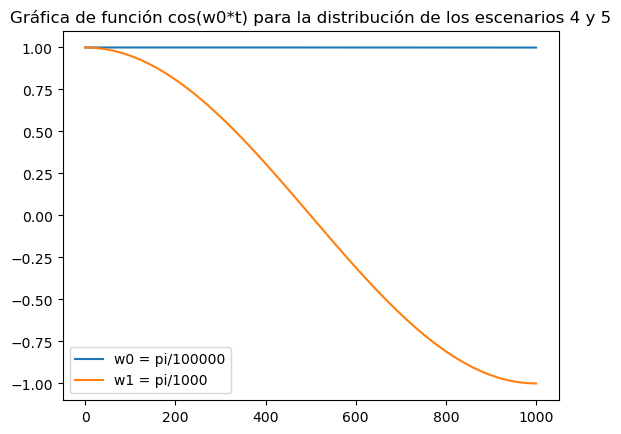

In [86]:
# definir vector de iteraciones t 
t = np.linspace(0, 1000)

# definir w0 para cada escenario
omega1 = np.pi/100000
omega2 = np.pi/1000

# aplicar  funcion cos(w0*t) para ambos escenarios
cos_omega1t = np.cos(omega1*t)
cos_omega2t = np.cos(omega2*t)

# Plot the two functions on the same graph
plt.plot(t, cos_omega1t, label='w0 = pi/100000')
plt.plot(t, cos_omega2t, label='w1 = pi/1000')
plt.title('Gráfica de función cos(w0*t) para la distribución de los escenarios 4 y 5')
plt.legend()
plt.show()

Como se puede observar para la gráfica de la función coseno, se observa que para el escenario 4, el factor $\pi/100000 *t$ tiende a 0 sin importar las variaciones de t a partir del número de iteraciones entonces el factor $cos(\pi/100000 *t)$ que determina la media $\mu$ de la distribución es 1 siempre, NO hay variación y es un caso de baja frecuencia. Entonces el escenario 4 se considera un caso estacionario.

Por otro lado se observa que para el escenario 5, el factor $\pi/1000 *t$ ya no tiende a 0 y que a medida que aumenta t (el número de iteraciones) se tiene una variación negativa de la función $cos(\pi/100000 *t)$ que determina la media $\mu$, para valores entre [-1,1] de la distribución entonces hay variaciones, y se tiene un caso no estacionario de alta frecuencia.

## Escogencia de tasa de aprendizaje 

En seguida, se realizó la implementación de las métricas de evaluación de retorno promedio (G) y porcentaje de acciones óptimas ponderadas en el número de experimentos (N=1000), comparando los 2 grupos de tasas de aprendizaje constante y las tasas de aprendizaje variables para determinar la tasa de aprendizaje adecuada para los escenarios  run_env_4 y run_env_5, teniendo en cuenta las condiciones de convergencia de las tasas de aprendizaje para casos no estacionarios.

El método de recompensa promedio ponderada soluciona el problema de n-bandits y actualiza los vectores de recompensa promedio ponderada de manera incremental mediante la siguiente ecuación:

$ rrp = [rrp[j] + (1/i)*(recompensa[j]-rrp[j])$ for j in range $recompensa$

En donde para cada iteración j, el algoritmo asigna la diferencia entre la recompensa actual de la iteración y la recompensa ponderada hasta el experimento i, obteniendo así un promedio ponderado por cada recompensa para cada interación j, ponderando la recompensa en i experimentos.

In [87]:
# def: Plot recompensa promedio ponderada N veces
# params: N=veces que se repite el experimento/ponderado, n=número de iteraciones/time-step, actions= bandit n-acciones, env=ambiente/escenario de RL con n-bandits
# params: hiper-parámetros de algoritmos. eps=probabilida de acción aleatoria en método e-greedy,v0_egreedy=inicialización optimista,v0=inicialización vector de retorno, c=balance valor estimado y incertidumbre, alpha=sensibilidad gradiente

# returns: 
# retornos_recompensa_prom_egreedy = lista de "retorno" de recompensa promedio ponderada método e-greedy

def recompensa_promedio_ponderada (N,n,actions,env,eps,v0_egreedy,alpha_n):
    # Plot recompensa promedio ponderada  
    fig=plt.figure(figsize=(10, 7))    
    # inicializar listas retorno de recompensa promedio para cada uno de los métodos    
    retornos_recompensa_prom_egreedy = np.zeros(n)    
    # itera sobre N veces que repite el experimento
    for i in range(1,N):            
        ### método e-greedy
        # obtener listas de método e-greedy
        recompensa_list,retornos_list,action_selected,n_select_list = metodo_e_greedy2(actions,n,eps,v0_egreedy,env)  
            
        # agregar elementos a la lista de retorno de recompensa promedio (incremental-asignación por lista j )
        retornos_recompensa_prom_egreedy = [retornos_recompensa_prom_egreedy[j] + (1/i)*(recompensa_list[j]-retornos_recompensa_prom_egreedy[j]) for j in range(len(recompensa_list))]     
            
        # Se reinician los ambientes/entornos en cada experimento
        bandit_envs.reset()

    plt.plot(retornos_recompensa_prom_egreedy) # plot "retorno" de recompensa promedio ponderada método e-greedy
    
    # inicializar listas retorno de recompensa promedio para cada uno de los métodos    
    retornos_recompensa_prom_egreedy = np.zeros(n)    
    # itera sobre N veces que repite el experimento
    for i in range(1,N):            
        ### método e-greedy
        # obtener listas de método e-greedy
        recompensa_list,retornos_list,action_selected,n_select_list = metodo_e_greedy3(actions,n,eps,v0_egreedy,env)  
            
        # agregar elementos a la lista de retorno de recompensa promedio (incremental-asignación por lista j )
        retornos_recompensa_prom_egreedy = [retornos_recompensa_prom_egreedy[j] + (1/i)*(recompensa_list[j]-retornos_recompensa_prom_egreedy[j]) for j in range(len(recompensa_list))]     
            
        # Se reinician los ambientes/entornos en cada experimento
        bandit_envs.reset()

    plt.plot(retornos_recompensa_prom_egreedy) # plot "retorno" de recompensa promedio ponderada método e-greedy

    for alpha in alpha_n:
        
        # inicializar listas retorno de recompensa promedio para cada uno de los métodos
        
        retornos_recompensa_prom_egreedy = np.zeros(n)
        
        # itera sobre N veces que repite el experimento
        for i in range(1,N):
            
            # generar vector de retornos de recompensa para todos los métodos

            ### método e-greedy
            # obtener listas de método e-greedy
            recompensa_list,retornos_list,action_selected,n_select_list = metodo_e_greedy1(actions,n,eps,v0_egreedy,env,alpha)  
            
            # agregar elementos a la lista de retorno de recompensa promedio (incremental-asignación por lista j )
            retornos_recompensa_prom_egreedy = [retornos_recompensa_prom_egreedy[j] + (1/i)*(recompensa_list[j]-retornos_recompensa_prom_egreedy[j]) for j in range(len(recompensa_list))]     
            
            # Se reinician los ambientes/entornos en cada experimento
            bandit_envs.reset()
            
        plt.plot(retornos_recompensa_prom_egreedy) # plot "retorno" de recompensa promedio ponderada método e-greedy
        
    # labels
    plt.xlabel('t: time-step')
    plt.ylabel('Recompensa')
    plt.title('Retorno de recompensa promedio (Método e-greedy): N.= '+str(N) ) 
    plt.legend(['1/n','1/sqrt(n)',alpha_n[0],alpha_n[1],alpha_n[2]])
    plt.grid(True)
    plt.show()
    
    return retornos_recompensa_prom_egreedy


In [88]:
# def: Plot recompensa promedio ponderada N veces
# params: N=veces que se repite el experimento/ponderado, n=número de iteraciones/time-step, actions= bandit n-acciones, env=ambiente/escenario de RL con n-bandits
# params: hiper-parámetros de algoritmos. eps=probabilida de acción aleatoria en método e-greedy,v0_egreedy=inicialización optimista,v0=inicialización vector de retorno, c=balance valor estimado y incertidumbre, alpha=sensibilidad gradient


# returns: 
# retornos_recompensa_prom_egreedy = lista de "retorno" de recompensa promedio ponderada método e-greedy
def recompensa_promedio_ponderada2 (N,n,actions,env,eps,v0_egreedy,alpha_n):
    # Plot recompensa promedio ponderada  
    fig=plt.figure(figsize=(10, 7))    
    
    # inicializar listas retorno de recompensa promedio para cada uno de los métodos    
    retornos_recompensa_prom_egreedy = np.zeros(n)    
    # itera sobre N veces que repite el experimento
    for i in range(1,N):            
        ### método e-greedy
        # obtener listas de método e-greedy
        recompensa_list,retornos_list,action_selected,n_select_list = metodo_e_greedy2(actions,n,eps,v0_egreedy,env)  
            
        # agregar elementos a la lista de retorno de recompensa promedio (incremental-asignación por lista j )
        retornos_recompensa_prom_egreedy = [retornos_recompensa_prom_egreedy[j] + (1/i)*(recompensa_list[j]-retornos_recompensa_prom_egreedy[j]) for j in range(len(recompensa_list))]     
            
        # Se reinician los ambientes/entornos en cada experimento
        bandit_envs.reset()

    plt.plot(retornos_recompensa_prom_egreedy) # plot "retorno" de recompensa promedio ponderada método e-greedy
    
    # inicializar listas retorno de recompensa promedio para cada uno de los métodos    
    retornos_recompensa_prom_egreedy = np.zeros(n)    
    # itera sobre N veces que repite el experimento
    for i in range(1,N):            
        ### método e-greedy
        # obtener listas de método e-greedy
        recompensa_list,retornos_list,action_selected,n_select_list = metodo_e_greedy3(actions,n,eps,v0_egreedy,env)  
            
        # agregar elementos a la lista de retorno de recompensa promedio (incremental-asignación por lista j )
        retornos_recompensa_prom_egreedy = [retornos_recompensa_prom_egreedy[j] + (1/i)*(recompensa_list[j]-retornos_recompensa_prom_egreedy[j]) for j in range(len(recompensa_list))]     
            
        # Se reinician los ambientes/entornos en cada experimento
        bandit_envs.reset()

    plt.plot(retornos_recompensa_prom_egreedy) # plot "retorno" de recompensa promedio ponderada método e-greedy
    
    
    # inicializar listas retorno de recompensa promedio para cada uno de los métodos    
    retornos_recompensa_prom_egreedy = np.zeros(n)    
    # itera sobre N veces que repite el experimento
    for i in range(1,N):            
        ### método e-greedy
        # obtener listas de método e-greedy
        recompensa_list,retornos_list,action_selected,n_select_list = metodo_e_greedy4(actions,n,eps,v0_egreedy,env)  
            
        # agregar elementos a la lista de retorno de recompensa promedio (incremental-asignación por lista j )
        retornos_recompensa_prom_egreedy = [retornos_recompensa_prom_egreedy[j] + (1/i)*(recompensa_list[j]-retornos_recompensa_prom_egreedy[j]) for j in range(len(recompensa_list))]     
            
        # Se reinician los ambientes/entornos en cada experimento
        bandit_envs.reset()

    plt.plot(retornos_recompensa_prom_egreedy) # plot "retorno" de recompensa promedio ponderada método e-greedy
    
    
    for alpha in alpha_n:
        
        # inicializar listas retorno de recompensa promedio para cada uno de los métodos
        
        retornos_recompensa_prom_egreedy = np.zeros(n)
        
        # itera sobre N veces que repite el experimento
        for i in range(1,N):
            
            # generar vector de retornos de recompensa para todos los métodos

            ### método e-greedy
            # obtener listas de método e-greedy
            recompensa_list,retornos_list,action_selected,n_select_list = metodo_e_greedy1(actions,n,eps,v0_egreedy,env,alpha)  
            
            # agregar elementos a la lista de retorno de recompensa promedio (incremental-asignación por lista j )
            retornos_recompensa_prom_egreedy = [retornos_recompensa_prom_egreedy[j] + (1/i)*(recompensa_list[j]-retornos_recompensa_prom_egreedy[j]) for j in range(len(recompensa_list))]     
            
            # Se reinician los ambientes/entornos en cada experimento
            bandit_envs.reset()
            
        plt.plot(retornos_recompensa_prom_egreedy) # plot "retorno" de recompensa promedio ponderada método e-greedy
        
    # labels
    plt.xlabel('t: time-step')
    plt.ylabel('Recompensa')
    plt.title('Retorno de recompensa promedio (Método e-greedy): N.= '+str(N) ) 
    plt.legend(['1/n','1/sqrt(n)','1/ln(n)',alpha_n[0],alpha_n[1],alpha_n[2]])
    plt.grid(True)
    plt.show()
    
    return retornos_recompensa_prom_egreedy



El porcentaje de acción óptima es una medida de cuántas veces ha seleccionado el algoritmo la acción óptima para un tiempo (time-step) dado. Para esto el algoritmo resuelve el problema de n-bandits, en seguida escoge la acción óptima para finalmente iterar por el vector de acciones seleccionadas. Finalmente obtiene la razón o porcentaje de acciones que selección como óptimas en cada instante de tiempo $n$. 

El porcentaje de acciones óptimas es una medida de eficacia y rapidez en la convergencia de los algoritmos propuestos de acción de valor.

In [89]:
# def: Plot % acción óptima ponderada N veces
# params: N=veces que se repite el experimento/ponderado, n=número de iteraciones/time-step, actions= bandit n-acciones, env=ambiente/escenario de RL con n-bandits
# params: hiper-parámetros de algoritmos. eps=probabilida de acción aleatoria en método e-greedy,v0_egreedy=inicialización optimista,v0=inicialización vector de retorno, c=balance valor estimado y incertidumbre, alpha=sensibilidad gradient

# returns: 
# porcentaje_accion_opt_ponderado_greedy= lista de % acción óptima ponderada método e-greedy
# porcentaje_accion_opt_ponderado_ubcmax= lista de % acción óptima ponderada método UBC.max
# porcentaje_accion_opt_ponderado_gradient= lista de % acción óptima ponderada método Gradient Bandit
def porcentaje_accion_opt_ponderado (N,n,actions,env,eps,v0_egreedy,alpha_n):
    
    # Plot recompensa promedio ponderada  
    fig=plt.figure(figsize=(10, 7))    
    
    porcentaje_accion_opt = np.zeros(n) # inicializar vector de porcentaje de accion óptima en 0 (tamaño n)
    porcentaje_accion_opt_ponderado_greedy = np.zeros(n) # inicializar vector de porcentaje de accion óptima ponderada en 0 (tamaño n)
        
    # itera sobre N veces que repite el experimento
    for i in range(1,N):        
        
        opt_count = 0 # contador accion optima 
            
        ### parámetros método e-greedy
        # resolver n-bandits con método e-greedy, obtener listas de recompensa, retorno, acciones seleccionadas y n.veces de acciones seleccionadas
        recompensa_list,retornos_list,action_selected,n_select_list = metodo_e_greedy2(actions,n,eps,v0_egreedy,env)
            
        accion_opt = mode(action_selected)   # accion optima= moda de lista acciones seleccionada 
            
        # iterar sobre n time-steps
        for k in range(1,n+1):
            # accion seleccionada en k es la accion optima
            if action_selected[k-1]==accion_opt:
                opt_count+=1
            porcentaje_accion_opt[k-1]=opt_count/(k)
                
        # agregar elementos a la lista de retorno de recompensa promedio (incremental-asignación por lista j )
        porcentaje_accion_opt_ponderado_greedy = [porcentaje_accion_opt_ponderado_greedy[j] + (1/i)*(porcentaje_accion_opt[j]-porcentaje_accion_opt_ponderado_greedy[j]) for j in range(len(action_selected))]     
            
        # Se reinician los ambientes/entornos en cada experimento
        bandit_envs.reset()
                
    plt.plot(porcentaje_accion_opt_ponderado_greedy) # plot de porcentaje accion optima ponderado método e-greedy


    porcentaje_accion_opt = np.zeros(n) # inicializar vector de porcentaje de accion óptima en 0 (tamaño n)
    porcentaje_accion_opt_ponderado_greedy = np.zeros(n) # inicializar vector de porcentaje de accion óptima ponderada en 0 (tamaño n)        
    # itera sobre N veces que repite el experimento
    for i in range(1,N):        
            
        opt_count = 0 # contador accion optima 
            
        ### parámetros método e-greedy
        # resolver n-bandits con método e-greedy, obtener listas de recompensa, retorno, acciones seleccionadas y n.veces de acciones seleccionadas
        recompensa_list,retornos_list,action_selected,n_select_list = metodo_e_greedy3(actions,n,eps,v0_egreedy,env)
            
        accion_opt = mode(action_selected)   # accion optima= moda de lista acciones seleccionada 
            
        # iterar sobre n time-steps
        for k in range(1,n+1):
            # accion seleccionada en k es la accion optima
            if action_selected[k-1]==accion_opt:
                opt_count+=1
            porcentaje_accion_opt[k-1]=opt_count/(k)
                
        # agregar elementos a la lista de retorno de recompensa promedio (incremental-asignación por lista j )
        porcentaje_accion_opt_ponderado_greedy = [porcentaje_accion_opt_ponderado_greedy[j] + (1/i)*(porcentaje_accion_opt[j]-porcentaje_accion_opt_ponderado_greedy[j]) for j in range(len(action_selected))]     
            
        # Se reinician los ambientes/entornos en cada experimento
        bandit_envs.reset()
                
    plt.plot(porcentaje_accion_opt_ponderado_greedy) # plot de porcentaje accion optima ponderado método e-greedy
    
    
    
    
    for alpha in alpha_n:
           
        porcentaje_accion_opt = np.zeros(n) # inicializar vector de porcentaje de accion óptima en 0 (tamaño n)
        porcentaje_accion_opt_ponderado_greedy = np.zeros(n) # inicializar vector de porcentaje de accion óptima ponderada en 0 (tamaño n)
        
        # itera sobre N veces que repite el experimento
        for i in range(1,N):        
            
            opt_count = 0 # contador accion optima 
            
            ### parámetros método e-greedy
            # resolver n-bandits con método e-greedy, obtener listas de recompensa, retorno, acciones seleccionadas y n.veces de acciones seleccionadas
            recompensa_list,retornos_list,action_selected,n_select_list = metodo_e_greedy1(actions,n,eps,v0_egreedy,env,alpha)
            
            accion_opt = mode(action_selected)   # accion optima= moda de lista acciones seleccionada 
            
            # iterar sobre n time-steps
            for k in range(1,n+1):
                # accion seleccionada en k es la accion optima
                if action_selected[k-1]==accion_opt:
                    opt_count+=1
                porcentaje_accion_opt[k-1]=opt_count/(k)
                
            # agregar elementos a la lista de retorno de recompensa promedio (incremental-asignación por lista j )
            porcentaje_accion_opt_ponderado_greedy = [porcentaje_accion_opt_ponderado_greedy[j] + (1/i)*(porcentaje_accion_opt[j]-porcentaje_accion_opt_ponderado_greedy[j]) for j in range(len(action_selected))]     
            
            # Se reinician los ambientes/entornos en cada experimento
            bandit_envs.reset()
            
        plt.plot(porcentaje_accion_opt_ponderado_greedy) # plot de porcentaje accion optima ponderado método e-greedy
    
    # labels
    plt.xlabel('t: time-step')
    plt.ylabel('% Acción óptima')
    plt.title(' Porcentaje de acción óptima ponderado: '+'N.= '+str(N) ) 
    plt.legend(['1/n','1/sqrt(n)',alpha_n[0],alpha_n[1],alpha_n[2]])
    plt.grid(True)
    plt.show()
    
    return porcentaje_accion_opt_ponderado_greedy 


In [90]:
# def: Plot % acción óptima ponderada N veces
# params: N=veces que se repite el experimento/ponderado, n=número de iteraciones/time-step, actions= bandit n-acciones, env=ambiente/escenario de RL con n-bandits
# params: hiper-parámetros de algoritmos. eps=probabilida de acción aleatoria en método e-greedy,v0_egreedy=inicialización optimista,v0=inicialización vector de retorno, c=balance valor estimado y incertidumbre, alpha=sensibilidad gradient

# returns: 
# porcentaje_accion_opt_ponderado_greedy= lista de % acción óptima ponderada método e-greedy
# porcentaje_accion_opt_ponderado_ubcmax= lista de % acción óptima ponderada método UBC.max
# porcentaje_accion_opt_ponderado_gradient= lista de % acción óptima ponderada método Gradient Bandit
def porcentaje_accion_opt_ponderado2(N,n,actions,env,eps,v0_egreedy,alpha_n):
    
    # Plot recompensa promedio ponderada  
    fig=plt.figure(figsize=(10, 7))    
    
    porcentaje_accion_opt = np.zeros(n) # inicializar vector de porcentaje de accion óptima en 0 (tamaño n)
    porcentaje_accion_opt_ponderado_greedy = np.zeros(n) # inicializar vector de porcentaje de accion óptima ponderada en 0 (tamaño n)
        
    # itera sobre N veces que repite el experimento
    for i in range(1,N):        
        
        opt_count = 0 # contador accion optima 
            
        ### parámetros método e-greedy
        # resolver n-bandits con método e-greedy, obtener listas de recompensa, retorno, acciones seleccionadas y n.veces de acciones seleccionadas
        recompensa_list,retornos_list,action_selected,n_select_list = metodo_e_greedy2(actions,n,eps,v0_egreedy,env)
            
        accion_opt = mode(action_selected)   # accion optima= moda de lista acciones seleccionada 
            
        # iterar sobre n time-steps
        for k in range(1,n+1):
            # accion seleccionada en k es la accion optima
            if action_selected[k-1]==accion_opt:
                opt_count+=1
            porcentaje_accion_opt[k-1]=opt_count/(k)
                
        # agregar elementos a la lista de retorno de recompensa promedio (incremental-asignación por lista j )
        porcentaje_accion_opt_ponderado_greedy = [porcentaje_accion_opt_ponderado_greedy[j] + (1/i)*(porcentaje_accion_opt[j]-porcentaje_accion_opt_ponderado_greedy[j]) for j in range(len(action_selected))]     
            
        # Se reinician los ambientes/entornos en cada experimento
        bandit_envs.reset()
                
    plt.plot(porcentaje_accion_opt_ponderado_greedy) # plot de porcentaje accion optima ponderado método e-greedy


    porcentaje_accion_opt = np.zeros(n) # inicializar vector de porcentaje de accion óptima en 0 (tamaño n)
    porcentaje_accion_opt_ponderado_greedy = np.zeros(n) # inicializar vector de porcentaje de accion óptima ponderada en 0 (tamaño n)        
    # itera sobre N veces que repite el experimento
    for i in range(1,N):        
            
        opt_count = 0 # contador accion optima 
            
        ### parámetros método e-greedy
        # resolver n-bandits con método e-greedy, obtener listas de recompensa, retorno, acciones seleccionadas y n.veces de acciones seleccionadas
        recompensa_list,retornos_list,action_selected,n_select_list = metodo_e_greedy3(actions,n,eps,v0_egreedy,env)
            
        accion_opt = mode(action_selected)   # accion optima= moda de lista acciones seleccionada 
            
        # iterar sobre n time-steps
        for k in range(1,n+1):
            # accion seleccionada en k es la accion optima
            if action_selected[k-1]==accion_opt:
                opt_count+=1
            porcentaje_accion_opt[k-1]=opt_count/(k)
                
        # agregar elementos a la lista de retorno de recompensa promedio (incremental-asignación por lista j )
        porcentaje_accion_opt_ponderado_greedy = [porcentaje_accion_opt_ponderado_greedy[j] + (1/i)*(porcentaje_accion_opt[j]-porcentaje_accion_opt_ponderado_greedy[j]) for j in range(len(action_selected))]     
            
        # Se reinician los ambientes/entornos en cada experimento
        bandit_envs.reset()
                
    plt.plot(porcentaje_accion_opt_ponderado_greedy) # plot de porcentaje accion optima ponderado método e-greedy
    
    porcentaje_accion_opt = np.zeros(n) # inicializar vector de porcentaje de accion óptima en 0 (tamaño n)
    porcentaje_accion_opt_ponderado_greedy = np.zeros(n) # inicializar vector de porcentaje de accion óptima ponderada en 0 (tamaño n)
        
    # itera sobre N veces que repite el experimento
    for i in range(1,N):        
        
        opt_count = 0 # contador accion optima 
            
        ### parámetros método e-greedy
        # resolver n-bandits con método e-greedy, obtener listas de recompensa, retorno, acciones seleccionadas y n.veces de acciones seleccionadas
        recompensa_list,retornos_list,action_selected,n_select_list = metodo_e_greedy4(actions,n,eps,v0_egreedy,env)
            
        accion_opt = mode(action_selected)   # accion optima= moda de lista acciones seleccionada 
            
        # iterar sobre n time-steps
        for k in range(1,n+1):
            # accion seleccionada en k es la accion optima
            if action_selected[k-1]==accion_opt:
                opt_count+=1
            porcentaje_accion_opt[k-1]=opt_count/(k)
                
        # agregar elementos a la lista de retorno de recompensa promedio (incremental-asignación por lista j )
        porcentaje_accion_opt_ponderado_greedy = [porcentaje_accion_opt_ponderado_greedy[j] + (1/i)*(porcentaje_accion_opt[j]-porcentaje_accion_opt_ponderado_greedy[j]) for j in range(len(action_selected))]     
            
        # Se reinician los ambientes/entornos en cada experimento
        bandit_envs.reset()
                
    plt.plot(porcentaje_accion_opt_ponderado_greedy) # plot de porcentaje accion optima ponderado método e-greedy
    
    
    for alpha in alpha_n:
           
        porcentaje_accion_opt = np.zeros(n) # inicializar vector de porcentaje de accion óptima en 0 (tamaño n)
        porcentaje_accion_opt_ponderado_greedy = np.zeros(n) # inicializar vector de porcentaje de accion óptima ponderada en 0 (tamaño n)
        
        # itera sobre N veces que repite el experimento
        for i in range(1,N):        
            
            opt_count = 0 # contador accion optima 
            
            ### parámetros método e-greedy
            # resolver n-bandits con método e-greedy, obtener listas de recompensa, retorno, acciones seleccionadas y n.veces de acciones seleccionadas
            recompensa_list,retornos_list,action_selected,n_select_list = metodo_e_greedy1(actions,n,eps,v0_egreedy,env,alpha)
            
            accion_opt = mode(action_selected)   # accion optima= moda de lista acciones seleccionada 
            
            # iterar sobre n time-steps
            for k in range(1,n+1):
                # accion seleccionada en k es la accion optima
                if action_selected[k-1]==accion_opt:
                    opt_count+=1
                porcentaje_accion_opt[k-1]=opt_count/(k)
                
            # agregar elementos a la lista de retorno de recompensa promedio (incremental-asignación por lista j )
            porcentaje_accion_opt_ponderado_greedy = [porcentaje_accion_opt_ponderado_greedy[j] + (1/i)*(porcentaje_accion_opt[j]-porcentaje_accion_opt_ponderado_greedy[j]) for j in range(len(action_selected))]     
            
            # Se reinician los ambientes/entornos en cada experimento
            bandit_envs.reset()
            
        plt.plot(porcentaje_accion_opt_ponderado_greedy) # plot de porcentaje accion optima ponderado método e-greedy
    
    # labels
    plt.xlabel('t: time-step')
    plt.ylabel('% Acción óptima')
    plt.title(' Porcentaje de acción óptima ponderado: '+'N.= '+str(N) ) 
    plt.legend(['1/n','1/sqrt(n)','1/ln(n)',alpha_n[0],alpha_n[1],alpha_n[2]])
    plt.grid(True)
    plt.show()
    
    return porcentaje_accion_opt_ponderado_greedy 



In [91]:
# def: Plot recompensa esperada
# params: N=veces que se repite el experimento/ponderado, n=número de iteraciones/time-step, actions= bandit n-acciones, env=ambiente/escenario de RL con n-bandits
# params: hiper-parámetros de algoritmos. eps=probabilidad de acción aleatoria en método e-greedy,v0_egreedy=inicialización optimista, alpha=lista de tasa de aprendizaje

# returns: 
# recompensa_esperada = recompensa esperada (valor esperado) de cada acción método e-greedy
def recompensa_esperada(N,n,actions,env,eps,v0_egreedy,alpha_n):
    
    # inicializar listas retorno de recompensa promedio para cada uno de los métodos    
    recompensa_esperada = np.zeros(actions.shape[0])    
    # itera sobre N veces que repite el experimento
    for i in range(1,N):            
        ### método e-greedy
        # obtener listas de método e-greedy
        recompensa_list,retornos_list,action_selected,n_select_list = metodo_e_greedy2(actions,n,eps,v0_egreedy,env)  
            
        # agregar elementos a la lista de retorno de recompensa promedio (incremental-asignación por lista j )
        #recompensa_esperada[i]= recompensa_esperada[j] + (1/i)*(retornos_list[j]-recompensa_esperada[j]) 
        
         # agregar elementos a la lista de retorno de recompensa esperada (incremental-asignación por lista j )
        recompensa_esperada = [recompensa_esperada[j] + (1/i)*(retornos_list[j]-recompensa_esperada[j]) for j in range(len(retornos_list))]     
             
        # Se reinician los ambientes/entornos en cada experimento
        bandit_envs.reset()
        
    # Plot recompensa esperada  
    fig=plt.figure(figsize=(10, 7))
    plt.bar([0,1,2,3,4,5,6,7,8,9,10,11],recompensa_esperada) # plot de recompensa esperada 
    plt.xlabel('# acción')
    plt.ylabel('Recompensa esperada')
    plt.title('Recompensa esperada(Valor Esperado) (Método e-greedy): N.= '+str(N) +' alpha: (1/n)' ) 
    plt.grid(True)
    plt.show()
    print('Recompensa esperada :',  recompensa_esperada)
    
    
    # inicializar listas retorno de recompensa promedio para cada uno de los métodos    
    recompensa_esperada = np.zeros(actions.shape[0])    
    # itera sobre N veces que repite el experimento
    for i in range(1,N):            
        ### método e-greedy
        # obtener listas de método e-greedy
        recompensa_list,retornos_list,action_selected,n_select_list = metodo_e_greedy3(actions,n,eps,v0_egreedy,env)  
            
         # agregar elementos a la lista de retorno de recompensa esperada (incremental-asignación por lista j )
        recompensa_esperada = [recompensa_esperada[j] + (1/i)*(retornos_list[j]-recompensa_esperada[j]) for j in range(len(retornos_list))]     
            
        # Se reinician los ambientes/entornos en cada experimento
        bandit_envs.reset()
         
    # Plot recompensa esperada  
    fig=plt.figure(figsize=(10, 7))
    plt.bar([0,1,2,3,4,5,6,7,8,9,10,11],recompensa_esperada) # plot de recompensa esperada 
    plt.xlabel('# acción')
    plt.ylabel('Recompensa esperada')
    plt.title('Recompensa esperada(Valor Esperado) (Método e-greedy): N.= '+str(N) +' alpha: 1/sqrt(n)' ) 
    plt.grid(True)
    plt.show()
    print('Recompensa esperada :',  recompensa_esperada)
    
    for alpha in alpha_n:
        
        # inicializar listas retorno de recompensa promedio para cada uno de los métodos    
        recompensa_esperada = np.zeros(actions.shape[0])    
        # itera sobre N veces que repite el experimento
        for i in range(1,N):
            
            # generar vector de retornos de recompensa para todos los métodos

            ### método e-greedy
            # obtener listas de método e-greedy
            recompensa_list,retornos_list,action_selected,n_select_list = metodo_e_greedy1(actions,n,eps,v0_egreedy,env,alpha)  
            
            # agregar elementos a la lista de retorno de recompensa esperada (incremental-asignación por lista j )
            recompensa_esperada = [recompensa_esperada[j] + (1/i)*(retornos_list[j]-recompensa_esperada[j]) for j in range(len(retornos_list))]     
         
            # Se reinician los ambientes/entornos en cada experimento
            bandit_envs.reset()
            
        # Plot recompensa esperada  
        fig=plt.figure(figsize=(10, 7))
        plt.bar([0,1,2,3,4,5,6,7,8,9,10,11],recompensa_esperada) # plot de recompensa esperada 
        plt.xlabel('# acción')
        plt.ylabel('Recompensa esperada')
        plt.title('Recompensa esperada(Valor Esperado) (Método e-greedy): N.= '+str(N) +' alpha: '+str(alpha) ) 
        plt.grid(True)
        plt.show()
        print('Recompensa esperada :',  recompensa_esperada)
    

    return recompensa_esperada

In [92]:
# def: Plot recompensa esperada
# params: N=veces que se repite el experimento/ponderado, n=número de iteraciones/time-step, actions= bandit n-acciones, env=ambiente/escenario de RL con n-bandits
# params: hiper-parámetros de algoritmos. eps=probabilidad de acción aleatoria en método e-greedy,v0_egreedy=inicialización optimista, alpha=lista de tasa de aprendizaje

# returns: 
# recompensa_esperada = recompensa esperada (valor esperado) de cada acción método e-greedy
def recompensa_esperada2(N,n,actions,env,eps,v0_egreedy,alpha_n):
    
    # inicializar listas retorno de recompensa promedio para cada uno de los métodos    
    recompensa_esperada = np.zeros(actions.shape[0])    
    # itera sobre N veces que repite el experimento
    for i in range(1,N):            
        ### método e-greedy
        # obtener listas de método e-greedy
        recompensa_list,retornos_list,action_selected,n_select_list = metodo_e_greedy2(actions,n,eps,v0_egreedy,env)  
            
        # agregar elementos a la lista de retorno de recompensa promedio (incremental-asignación por lista j )
        #recompensa_esperada[i]= recompensa_esperada[j] + (1/i)*(retornos_list[j]-recompensa_esperada[j]) 
        
         # agregar elementos a la lista de retorno de recompensa esperada (incremental-asignación por lista j )
        recompensa_esperada = [recompensa_esperada[j] + (1/i)*(retornos_list[j]-recompensa_esperada[j]) for j in range(len(retornos_list))]     
             
        # Se reinician los ambientes/entornos en cada experimento
        bandit_envs.reset()
    
    # Plot recompensa esperada  
    fig=plt.figure(figsize=(10, 7))
    plt.bar([0,1,2,3,4,5,6,7,8,9,10,11],recompensa_esperada) # plot de recompensa esperada 
    plt.xlabel('# acción')
    plt.ylabel('Recompensa esperada')
    plt.title('Recompensa esperada(Valor Esperado) (Método e-greedy): N.= '+str(N) +' alpha: 1/n' ) 
    plt.grid(True)
    plt.show()
    print('Recompensa esperada :',  recompensa_esperada)
    
    # inicializar listas retorno de recompensa promedio para cada uno de los métodos    
    recompensa_esperada = np.zeros(actions.shape[0])     
    # itera sobre N veces que repite el experimento
    for i in range(1,N):            
        ### método e-greedy
        # obtener listas de método e-greedy
        recompensa_list,retornos_list,action_selected,n_select_list = metodo_e_greedy3(actions,n,eps,v0_egreedy,env)  
            
         # agregar elementos a la lista de retorno de recompensa esperada (incremental-asignación por lista j )
        recompensa_esperada = [recompensa_esperada[j] + (1/i)*(retornos_list[j]-recompensa_esperada[j]) for j in range(len(retornos_list))]     
            
        # Se reinician los ambientes/entornos en cada experimento
        bandit_envs.reset()
        
    # Plot recompensa esperada  
    fig=plt.figure(figsize=(10, 7))
    plt.bar([0,1,2,3,4,5,6,7,8,9,10,11],recompensa_esperada) # plot de recompensa esperada 
    plt.xlabel('# acción')
    plt.ylabel('Recompensa esperada')
    plt.title('Recompensa esperada(Valor Esperado) (Método e-greedy): N.= '+str(N) +' alpha: 1/sqrt(n)' ) 
    plt.grid(True)
    plt.show()
    print('Recompensa esperada :',  recompensa_esperada)
    
    # inicializar listas retorno de recompensa promedio para cada uno de los métodos    
    recompensa_esperada = np.zeros(actions.shape[0])    
    # itera sobre N veces que repite el experimento
    for i in range(1,N):            
        ### método e-greedy
        # obtener listas de método e-greedy
        recompensa_list,retornos_list,action_selected,n_select_list = metodo_e_greedy4(actions,n,eps,v0_egreedy,env)  
        
        # agregar elementos a la lista de retorno de recompensa esperada (incremental-asignación por lista j )
        recompensa_esperada = [recompensa_esperada[j] + (1/i)*(retornos_list[j]-recompensa_esperada[j]) for j in range(len(retornos_list))]     
          
        # Se reinician los ambientes/entornos en cada experimento
        bandit_envs.reset()
         
    # Plot recompensa esperada  
    fig=plt.figure(figsize=(10, 7))
    plt.bar([0,1,2,3,4,5,6,7,8,9,10,11],recompensa_esperada) # plot de recompensa esperada 
    plt.xlabel('# acción')
    plt.ylabel('Recompensa esperada')
    plt.title('Recompensa esperada(Valor Esperado) (Método e-greedy): N.= '+str(N) +' alpha: 1/ln(n)' ) 
    plt.grid(True)
    plt.show()
    print('Recompensa esperada :',  recompensa_esperada)
    
    for alpha in alpha_n:
        
        # inicializar listas retorno de recompensa promedio para cada uno de los métodos    
        recompensa_esperada = np.zeros(actions.shape[0])    
        # itera sobre N veces que repite el experimento
        for i in range(1,N):
            
            # generar vector de retornos de recompensa para todos los métodos

            ### método e-greedy
            # obtener listas de método e-greedy
            recompensa_list,retornos_list,action_selected,n_select_list = metodo_e_greedy1(actions,n,eps,v0_egreedy,env,alpha)  
            
            # agregar elementos a la lista de retorno de recompensa esperada (incremental-asignación por lista j )
            recompensa_esperada = [recompensa_esperada[j] + (1/i)*(retornos_list[j]-recompensa_esperada[j]) for j in range(len(retornos_list))]     
         
            # Se reinician los ambientes/entornos en cada experimento
            bandit_envs.reset()
            
        # Plot recompensa esperada  
        fig=plt.figure(figsize=(10, 7))
        plt.bar([0,1,2,3,4,5,6,7,8,9,10,11],recompensa_esperada) # plot de recompensa esperada 
        plt.xlabel('# acción') 
        plt.ylabel('Recompensa esperada')
        plt.title('Recompensa esperada(Valor Esperado) (Método e-greedy): N.= '+str(N) +' alpha: '+str(alpha) ) 
        plt.grid(True)
        plt.show()    
        print('Recompensa esperada :',  recompensa_esperada)
        
    return recompensa_esperada


A continuación, se crea el n-Bandits con k=12 acciones llamando a la clase/módulo BanditEnvs modificada, en el cuál se implementaron a su vez los escenarios run_env_4 y run_env_5.

In [93]:
# se crea el n-Bandits con n=12 acciones
bandit_envs = BanditEnvs(k=12)
bandit_envs

# Escenario 4: pequeños cambios en la media $\mu$, baja frecuencia
### Distrubución normal con media $\mu = \beta_i + cos(w_0*t)$ y varianza $\sigma=1$, donde $w_0=\pi/100000$

Se presentan los resultados de retorno promedio ponderado y porcentaje de acción óptima comparando las tasas de aprendizaje altas [0.1,0.3,0.5] y las tasas de aprendizaje variables $\alpha=1/(N_t(a_i))$  y  $\alpha=1/(\sqrt(N_t(a_i)) )$  aplicando el método de acción de valor E-greedy, ponderando el retorno de la recompensa sobre 1000 experimentos.

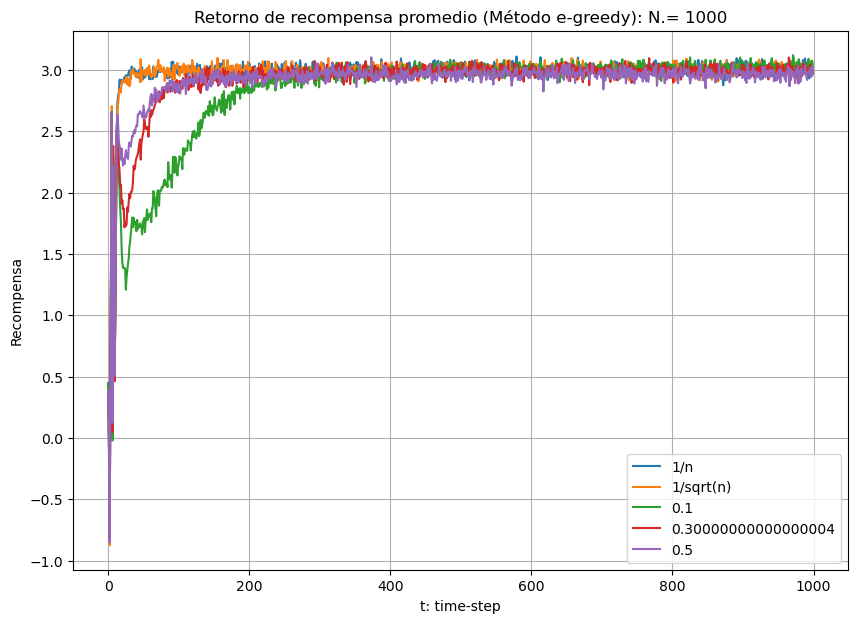

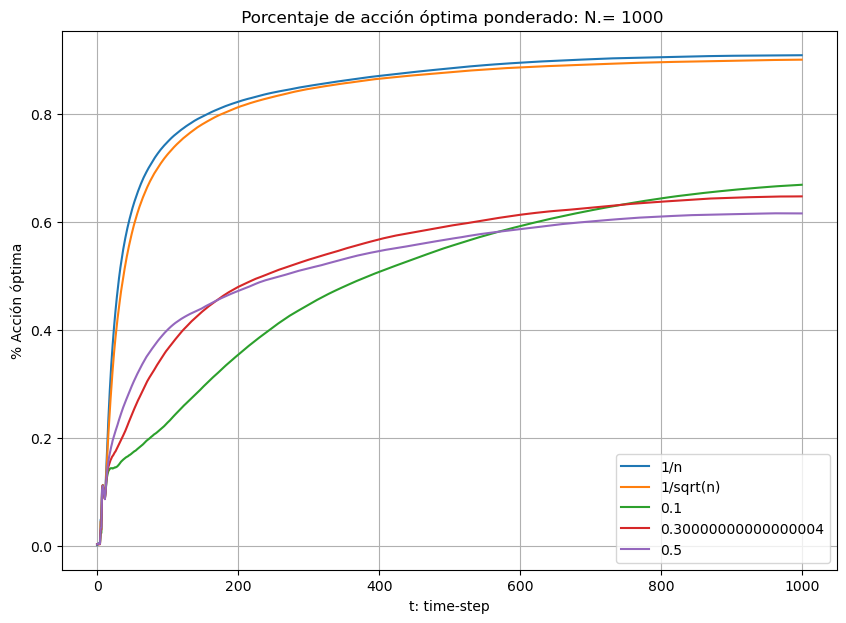

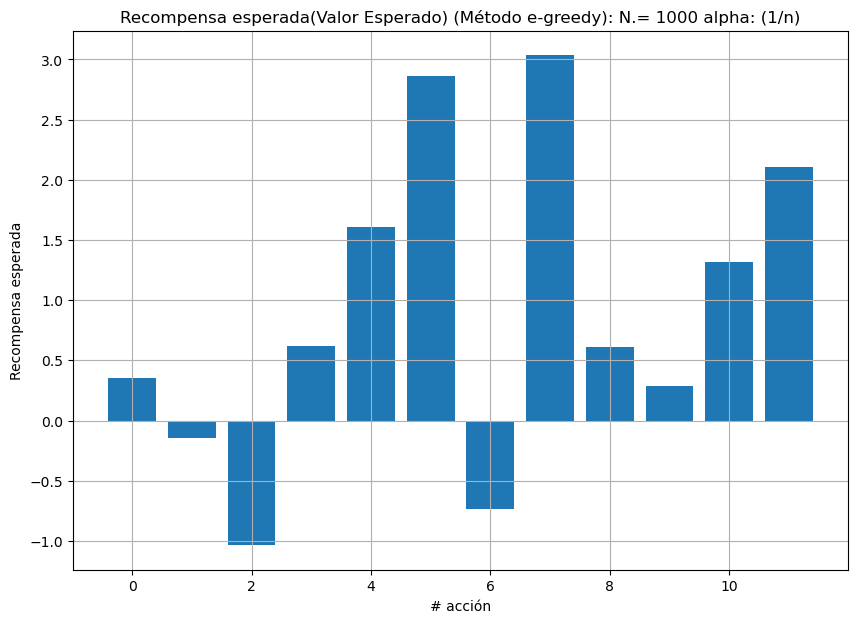

Recompensa esperada : [0.35686172760028034, -0.1477484133481914, -1.0352117371677585, 0.6181422174555022, 1.6082926531609685, 2.8617505642614534, -0.7361524207460286, 3.034616004199565, 0.6071675782111412, 0.28337576073745296, 1.3163458306899547, 2.103357044080566]


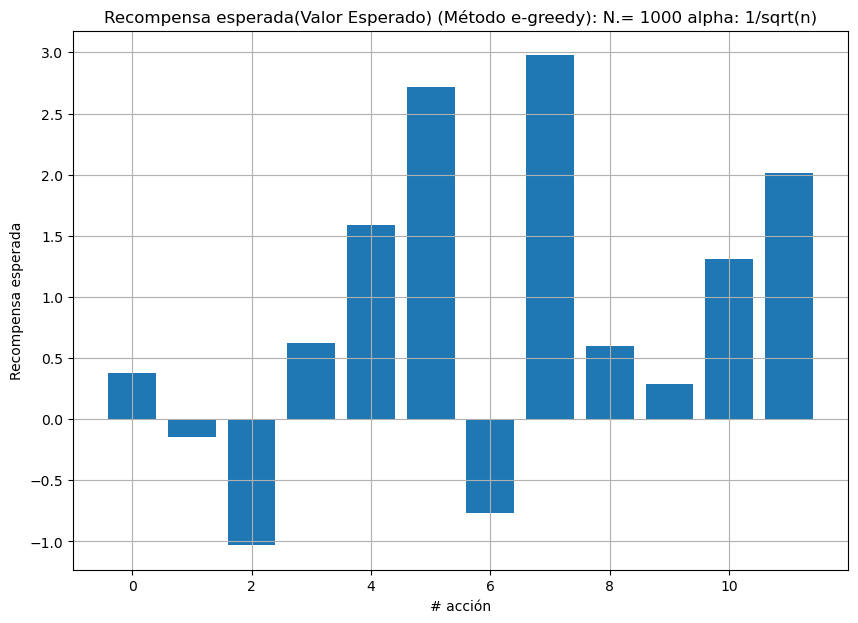

Recompensa esperada : [0.3793830879245797, -0.14392194601089497, -1.0304737429755653, 0.6239536553616842, 1.5865870984973423, 2.715948029922765, -0.7693288998095048, 2.976706425095141, 0.5956215998722015, 0.28616074200550473, 1.3089665607683134, 2.0158653620246234]


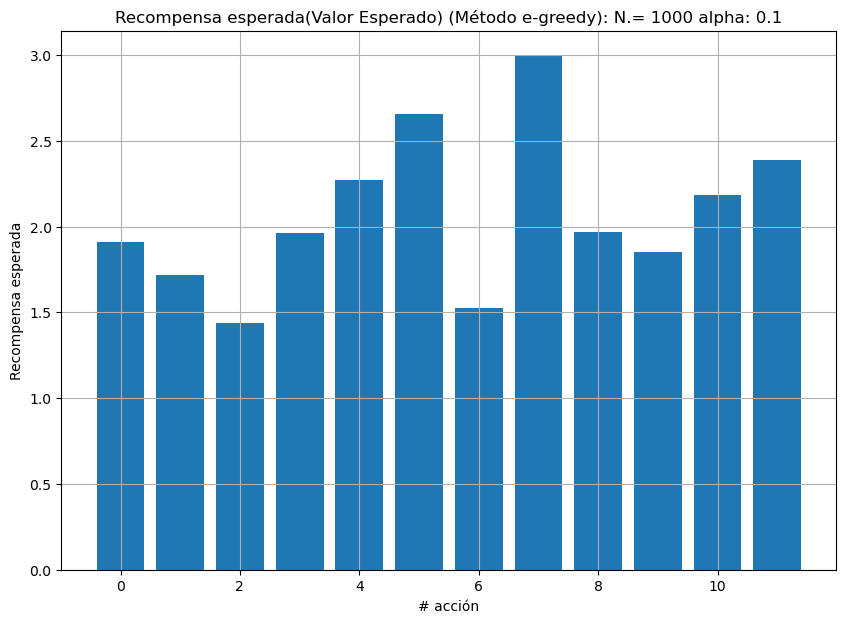

Recompensa esperada : [1.912175461830903, 1.720532984314002, 1.437453101525516, 1.9646056703598431, 2.2700069362135564, 2.657244019619695, 1.5246022145047524, 2.992146645341967, 1.9660850240107157, 1.8516959171607519, 2.1827346299685915, 2.388455700466184]


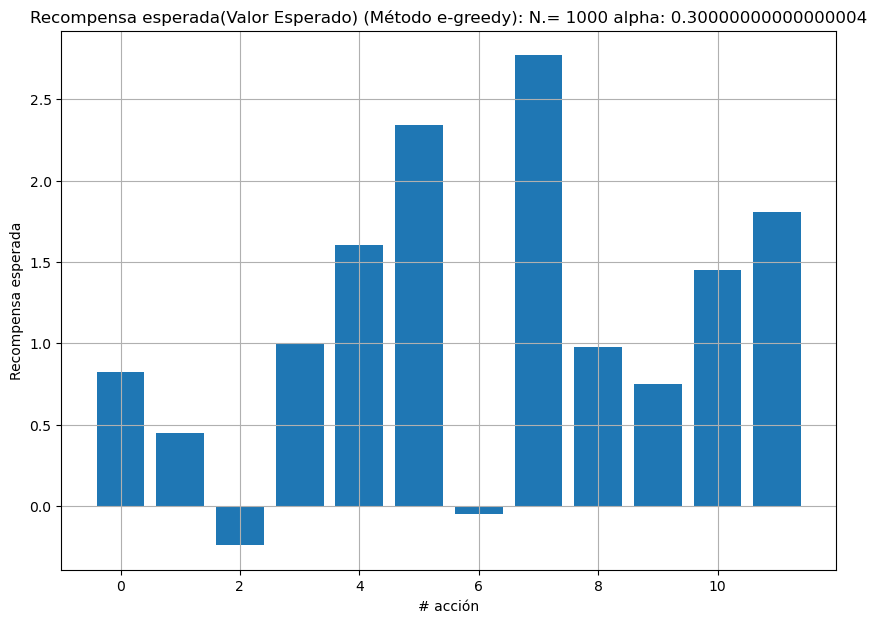

Recompensa esperada : [0.8211329398610475, 0.4510281019855893, -0.2400416019181824, 0.998798603063551, 1.6028035694333718, 2.3395408606234005, -0.04809413264448919, 2.769541264980073, 0.9801806832270753, 0.7505309425137273, 1.448337102884541, 1.8086020814113013]


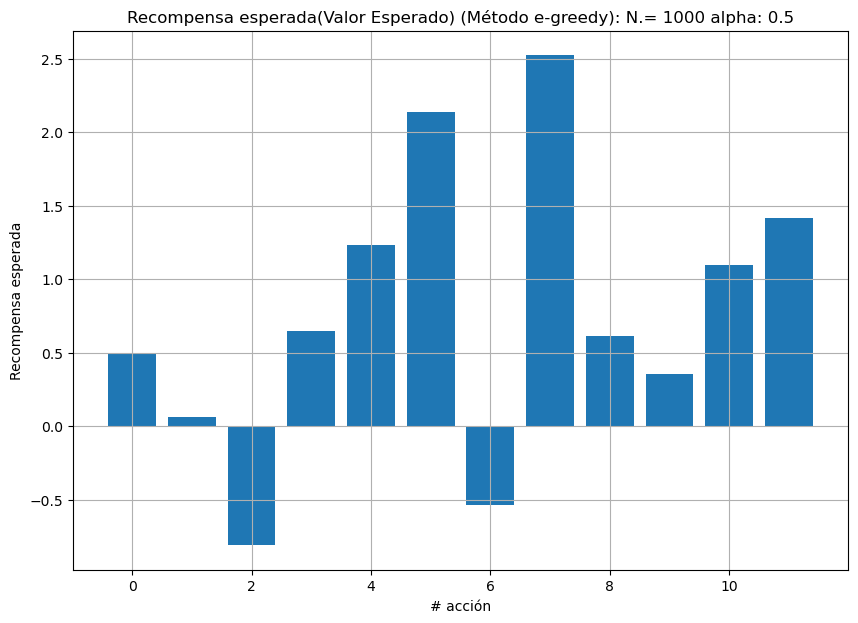

Recompensa esperada : [0.4955202222019138, 0.06466829916537122, -0.8109980979118245, 0.6463606169527286, 1.2334582423567908, 2.139117166140811, -0.5395503927909227, 2.52480736847817, 0.6149442246820779, 0.35196066753326793, 1.0986323586918485, 1.4176965469010594]


In [94]:
# Resultados: Recompensa promedio ponderada y Porcentaje de acciones óptimas 
N=1000 # numero de experimentos
n=1000 # time-step/iteraciones
actions = np.arange(0,12,1) # numero de bandits/acciones
env=4 # ambiente/escenario
eps=0.05
v0_egreedy = 5

alpha_n = np.linspace(0.1, 0.5, num=3)

retornos_recompensa_prom_egreedy = recompensa_promedio_ponderada (N,n,actions,env,eps,v0_egreedy,alpha_n)
porcentaje_accion_opt_ponderado_greedy  = porcentaje_accion_opt_ponderado (N,n,actions,env,eps,v0_egreedy,alpha_n)
recompensa_esperada = recompensa_esperada(N,n,actions,env,eps,v0_egreedy,alpha_n)


Se presentan los resultados de retorno promedio ponderado y porcentaje de acción óptima comparando las tasas de aprendizaje pequeñas [0.01,0.03,0.05] y las tasas de aprendizaje variables $\alpha=1/(N_t(a_i))$,  $\alpha=1/(\sqrt(N_t(a_i)) )$,   $\alpha=1/(\ln(N_t(a_i)) )$  aplicando el método de acción de valor E-greedy, ponderando el retorno de la recompensa sobre 1000 experimentos.

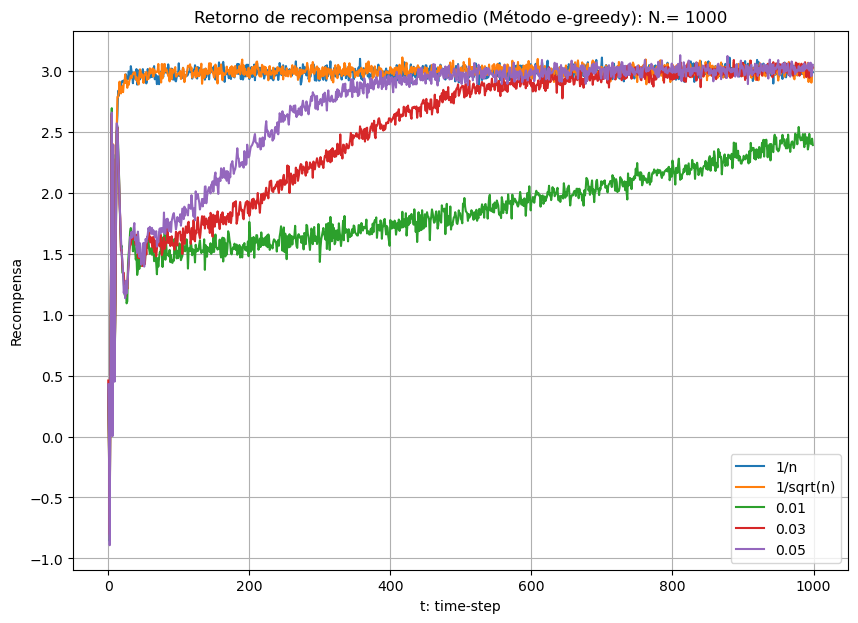

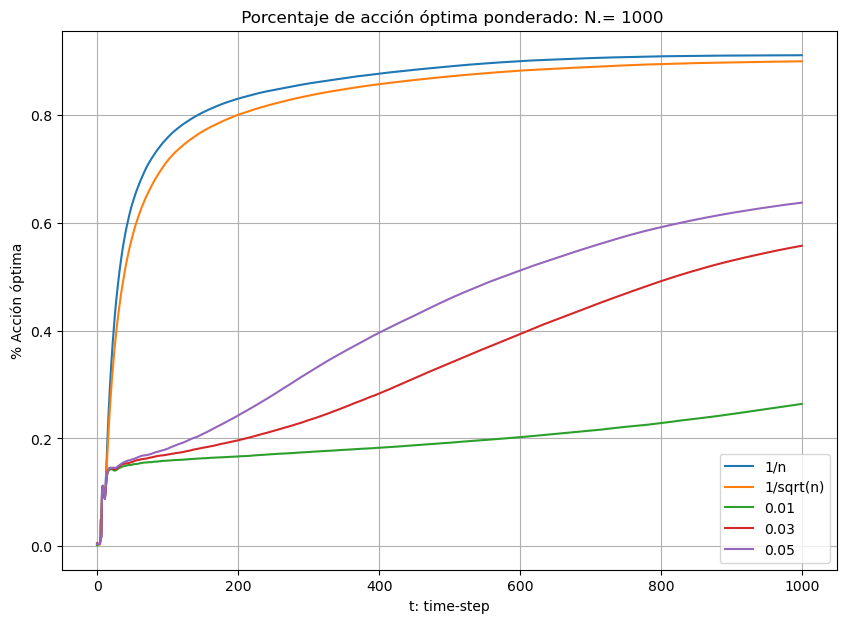

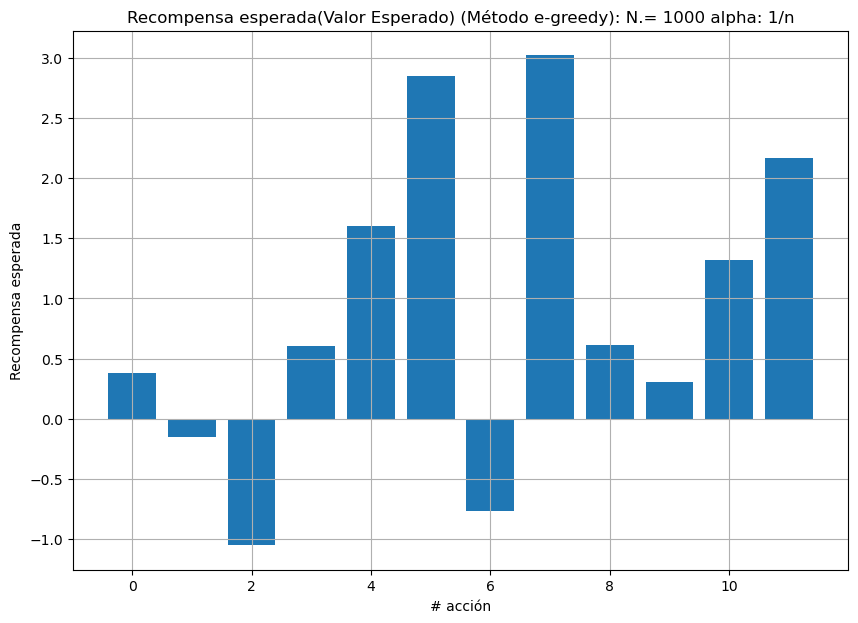

Recompensa esperada : [0.37818036987689696, -0.1503788297461764, -1.0520319946229535, 0.6033321380202509, 1.602037145848752, 2.849151194944663, -0.7692876286107203, 3.0226606565321466, 0.6139657871909333, 0.3052614299000279, 1.3237770569020504, 2.163882358610741]


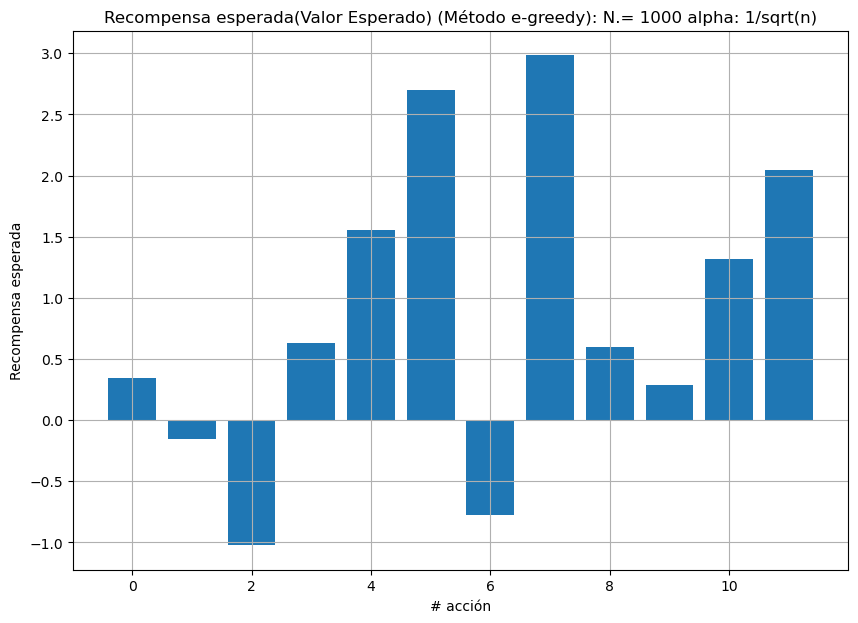

Recompensa esperada : [0.3432901036950396, -0.15649794463192657, -1.0226377678388492, 0.635145546999309, 1.555705215908146, 2.7040672451142402, -0.7771225139048263, 2.9847623012905777, 0.5978239687388172, 0.28572082391696024, 1.3218206894704523, 2.0425564394277163]


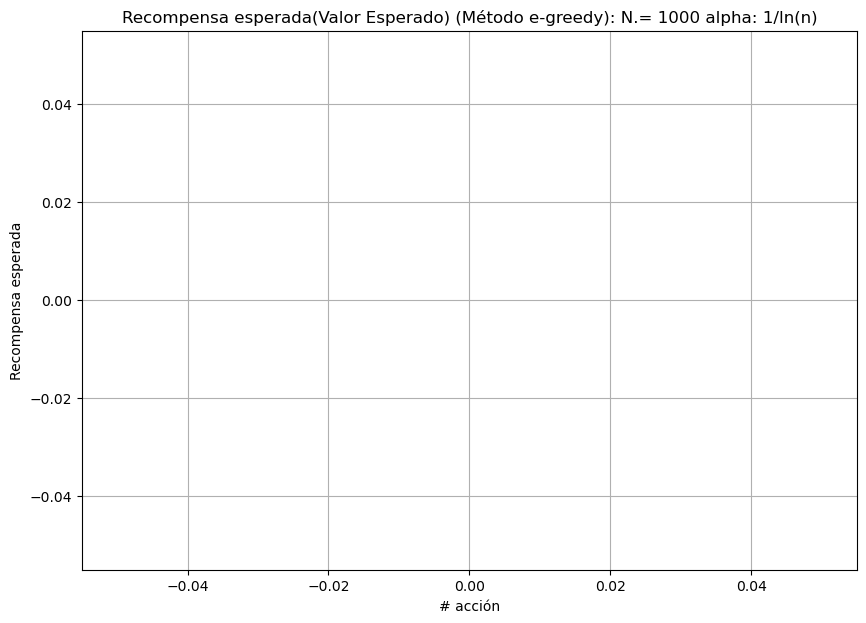

Recompensa esperada : [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]


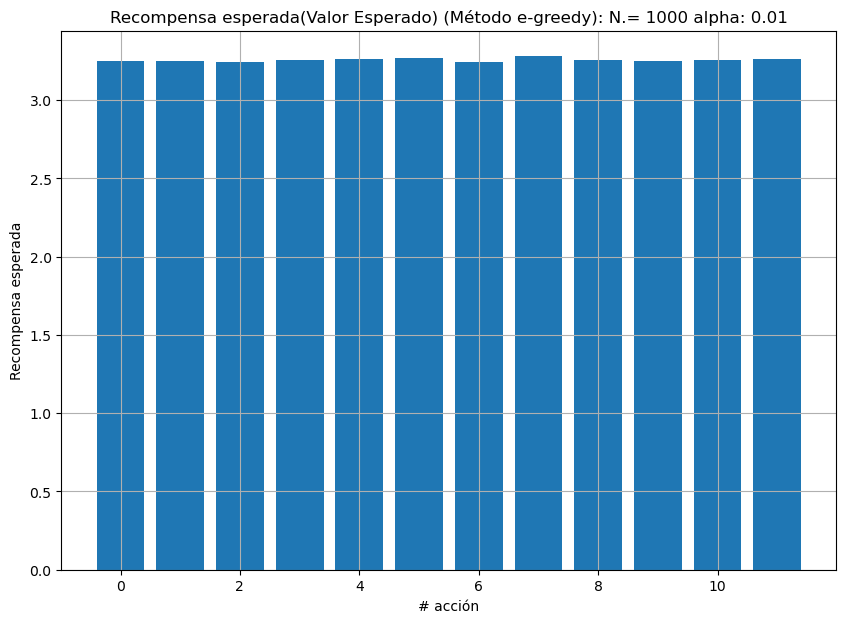

Recompensa esperada : [3.253379432199672, 3.24899518458544, 3.243809226707499, 3.255573639001675, 3.261692066240799, 3.2713772798302387, 3.2452410599907298, 3.2802644726655976, 3.2552338910407848, 3.252962565883821, 3.2599074976961706, 3.264278563974314]


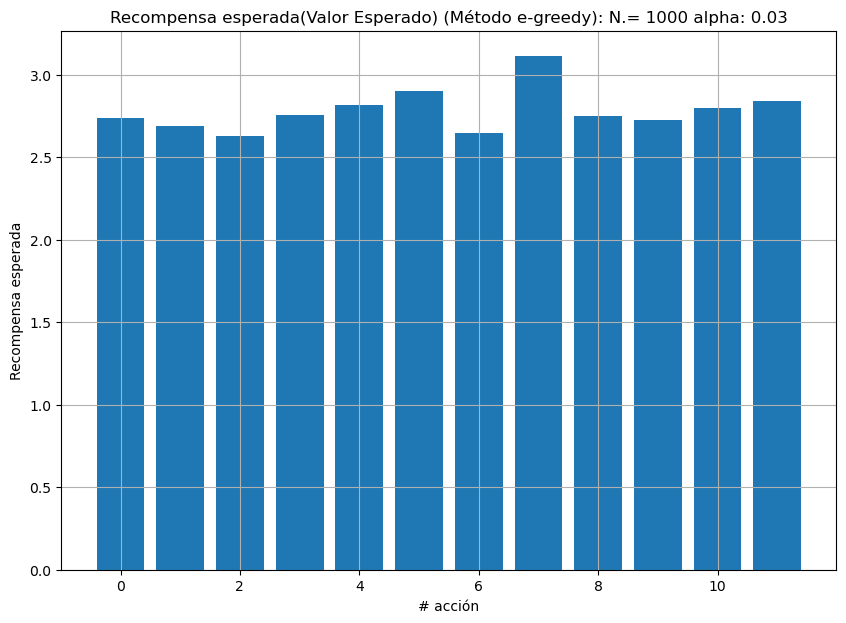

Recompensa esperada : [2.7369047855904673, 2.6914533810963, 2.6291070235832557, 2.7534886921329154, 2.8166910060081367, 2.9040836191414674, 2.6457968544570316, 3.1116377640506765, 2.7520420029491683, 2.7273440539414104, 2.7976783388105333, 2.8416588169509756]


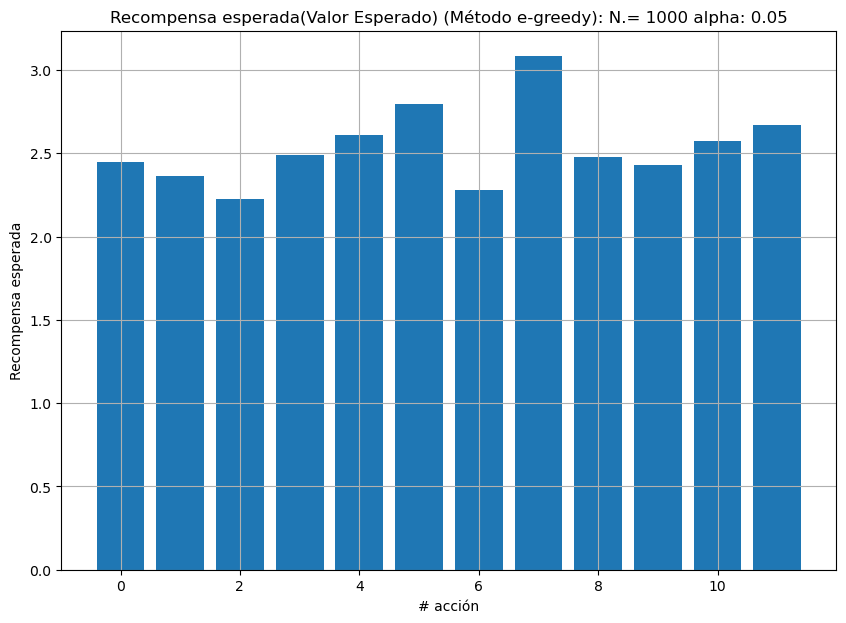

Recompensa esperada : [2.4470229780023978, 2.3619802801080314, 2.225697447223386, 2.491141685490639, 2.608892555998013, 2.7959119120119507, 2.2796156962637837, 3.0816744252616557, 2.4764463139523376, 2.432490451264045, 2.576516361118507, 2.6702310201204535]


In [95]:
# Resultados: Recompensa promedio ponderada y Porcentaje de acciones óptimas 
N=1000 # numero de experimentos
n=1000 # time-step/iteraciones
actions = np.arange(0,12,1) # numero de bandits/acciones
env=4 # ambiente/escenario
eps=0.05
v0_egreedy = 5

alpha_n = np.linspace(0.01, 0.05, num=3)

retornos_recompensa_prom_egreedy = recompensa_promedio_ponderada (N,n,actions,env,eps,v0_egreedy,alpha_n)
porcentaje_accion_opt_ponderado_greedy  = porcentaje_accion_opt_ponderado (N,n,actions,env,eps,v0_egreedy,alpha_n)
recompensa_esperada = recompensa_esperada2(N,n,actions,env,eps,v0_egreedy,alpha_n)



Como se puede observar en las Figuras anteriores, las tasas de aprendizajes altas para el escenario run_env_4 de baja frecuencia con pequeños cambios sobre la media $\mu$ de la distribución generan mayor retorno promedio con un valor de retorno 3 antes de las 200 iteraciones, mientras que para las tasas de aprendizajes pequeñas les toma un mayor número de iteraciones (más de  400 para $\alpha_i = 0.05$) de alcanzar este valor. Para una tasas de aprendizaje constante $\alpha_i = 0.01$ en el escenario de baja frecuencia ni siquiera ha convergido a la solución del problema de n-Bandit de 2.5, mientras que las tasas de aprendizajes grandes aprovechan las bajas variaciones en la distribución ($\mu$) y convergen más rápidamente a la solución.

Sin embargo, se observa claramente que para una tasa de aprendizaje variable (método de promedio de muestra) se obtiene el mayor retorno a lo largo del tiempo donde la curva de retorno con $\alpha=1/(N_t(a_i))$ está siempre por encima de las otras, además que el porcentaje de acciones óptimas seleccionadas es el mayor con esta tasa de aprendizaje con un valor aproximado al 90% de las acciones óptimas tomadas, mientras que para tasas de aprendizaje constante altas el mayor porcentaje de acciones tomadas fue cercano a apenas el 70% de las acciones seleccionadas. Para tasas de aprendizaje constante pequeñas el mayor porcentaje de acciones tomadas fue cercano a menos del 65% de las acciones seleccionadas y para una tasa constante muy pequeña de $\alpha_i = 0.01$ para 1000 iteraciones el algoritmo no ha tomado ni el 20% de las acciones óptimas en promedio. Por otro lado, a partir de las gráficas de recompensa esperada (valor esperado)para la tasa de aprendizaje variable en función de n veces escogida la acción $\alpha=1/(N_t(a_i))$  de cada acción se observa que la acción óptima para el escenario4 es la acción 7, y que el estimativo del valor esperado para la tasas $\alpha=1/(N_t(a_i))$ es congruente con los resultados obtenidos para el retorno, de modo que tanto la escogencia de la acción óptima que resuleve el problema n-Bandits (acción óptima es 7) así como el estimado del valor esperado de la distribución es el mismo, debido a la naturaleza estacionaria de la distribución.


A partir de estos resultados, junto con los resultados presentados en la literatura por los autores Sutton y Barto de las 2 condiciones de convergencia que se satisfacen para $\alpha=1/(N_t(a_i))$, entonces se argumenta la selección de esta tasa de aprendizaje para el escenario run_env_4 de baja frecuencia con pequeñas variaciones sobre la media $\mu$

# Escenario 5: grandes cambios en la media $\mu$, alta frecuencia
### Distrubución normal con media $\mu = \beta_i + cos(w_0*t)$ y varianza $\sigma=1$, donde $w_0=\pi/1000$

Se presentan los resultados de retorno promedio ponderado y porcentaje de acción óptima comparando las tasas de aprendizaje altas [0.1,0.3,0.5] y las tasas de aprendizaje variables $\alpha=1/(N_t(a_i))$  y  $\alpha=1/(\sqrt(N_t(a_i)) )$  aplicando el método de acción de valor E-greedy, ponderando el retorno de la recompensa sobre 1000 experimentos.

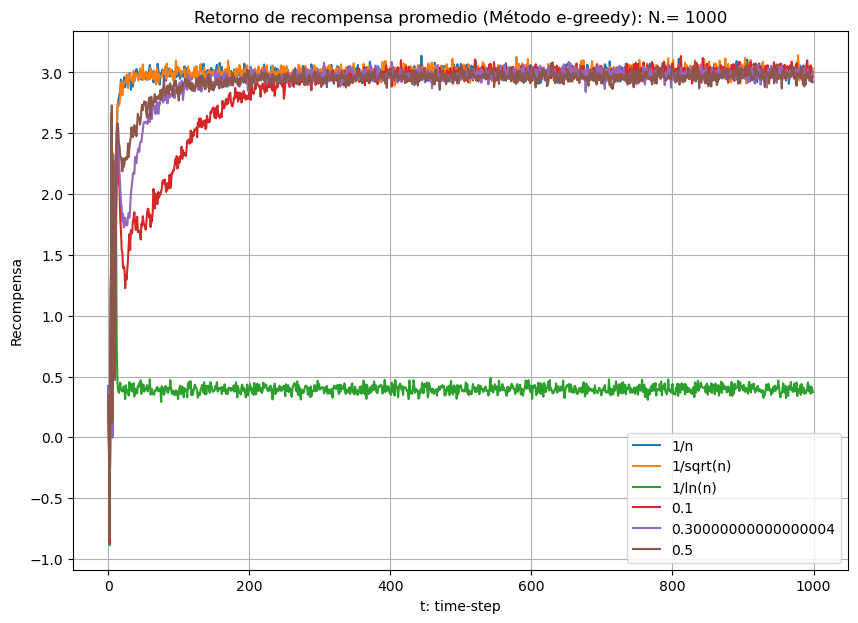

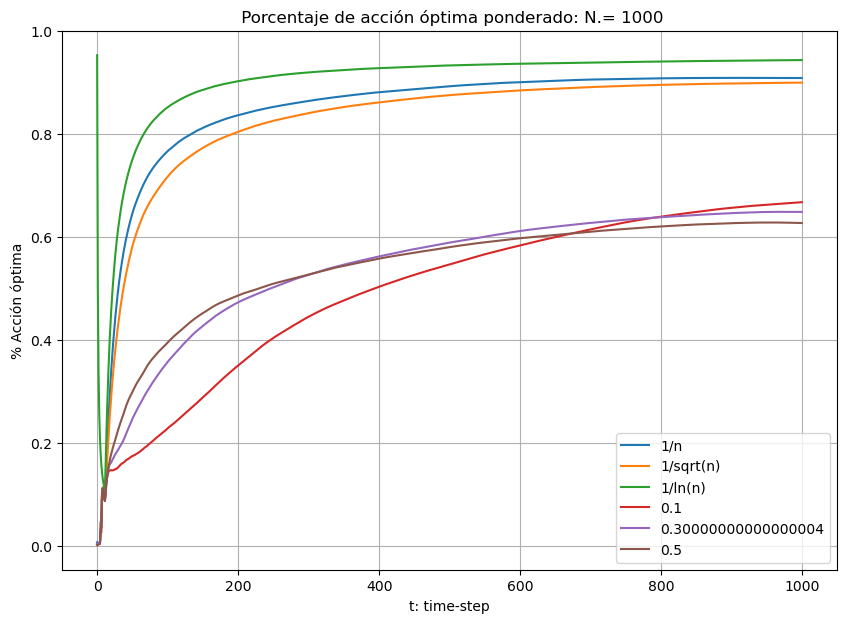

TypeError: 'list' object is not callable

In [98]:
# Resultados: Recompensa promedio ponderada y Porcentaje de acciones óptimas 
N=1000 # numero de experimentos
n=1000 # time-step/iteraciones
actions = np.arange(0,12,1) # numero de bandits/acciones
env=5 # ambiente/escenario
eps=0.05
v0_egreedy = 5

alpha_n = np.linspace(0.1, 0.5, num=3)

retornos_recompensa_prom_egreedy = recompensa_promedio_ponderada2(N,n,actions,env,eps,v0_egreedy,alpha_n)
porcentaje_accion_opt_ponderado_greedy  = porcentaje_accion_opt_ponderado2(N,n,actions,env,eps,v0_egreedy,alpha_n)
recompensa_esperada = recompensa_esperada(N,n,actions,env,eps,v0_egreedy,alpha_n)


Se presentan los resultados de retorno promedio ponderado y porcentaje de acción óptima comparando las tasas de aprendizaje pequeñas [0.01,0.03,0.05] y las tasas de aprendizaje variables $\alpha=1/(N_t(a_i))$,  $\alpha=1/(\sqrt(N_t(a_i)) )$,   $\alpha=1/(\ln(N_t(a_i)) )$  aplicando el método de acción de valor E-greedy, ponderando el retorno de la recompensa sobre 1000 experimentos.

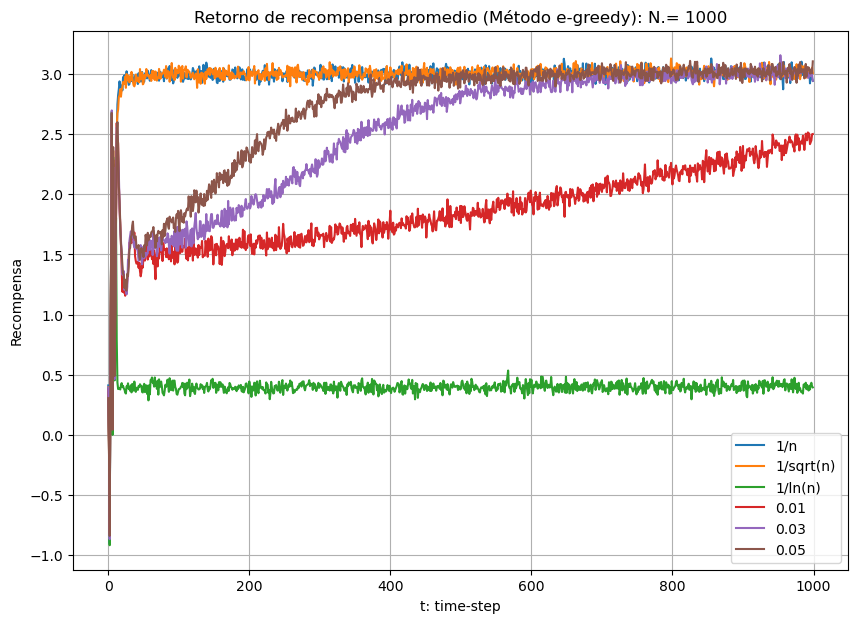

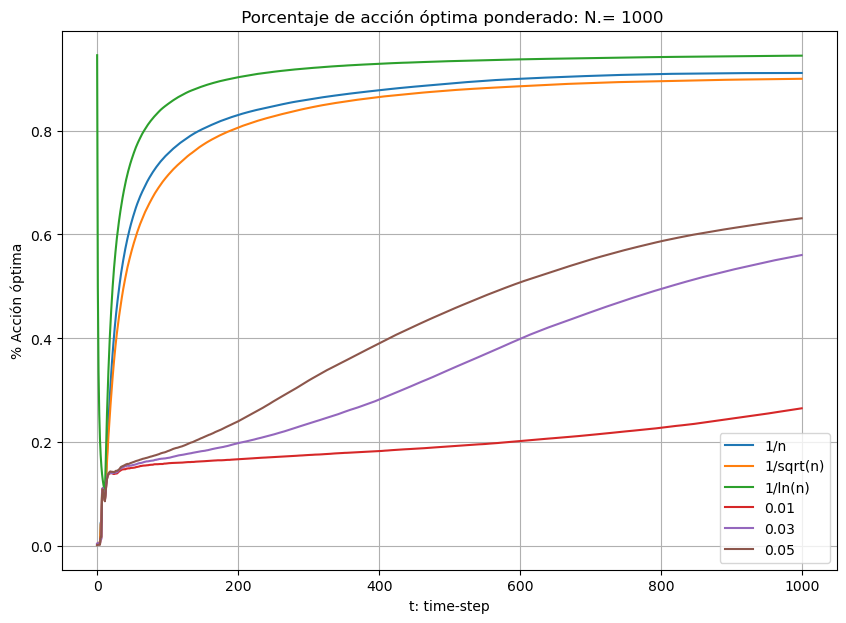

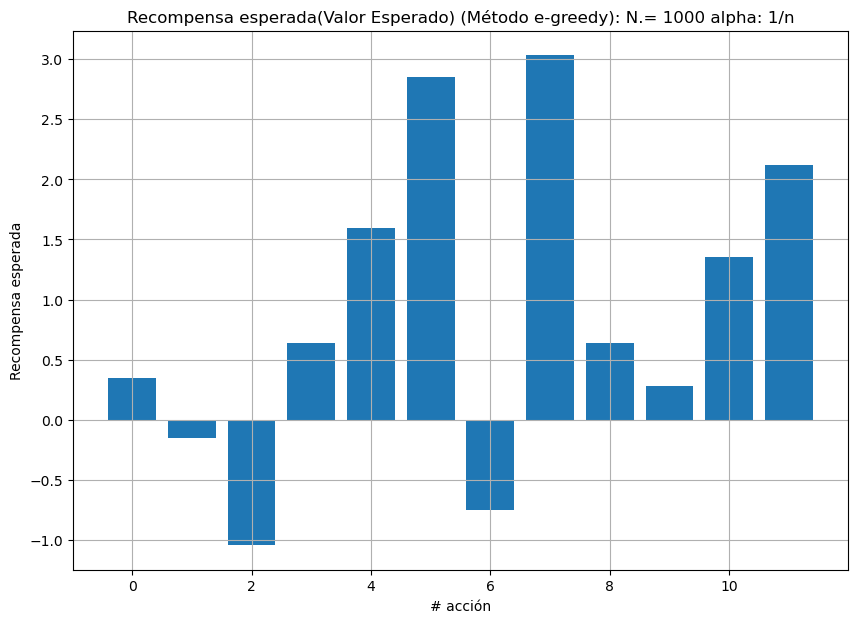

Recompensa esperada : [0.3513350514702874, -0.15396011811649687, -1.0438567251658215, 0.6360860195784299, 1.5962564793214322, 2.8528820281894443, -0.7480474923760521, 3.0331091553008602, 0.6389193965768475, 0.2790586773285967, 1.3515184449096194, 2.1174587376502307]


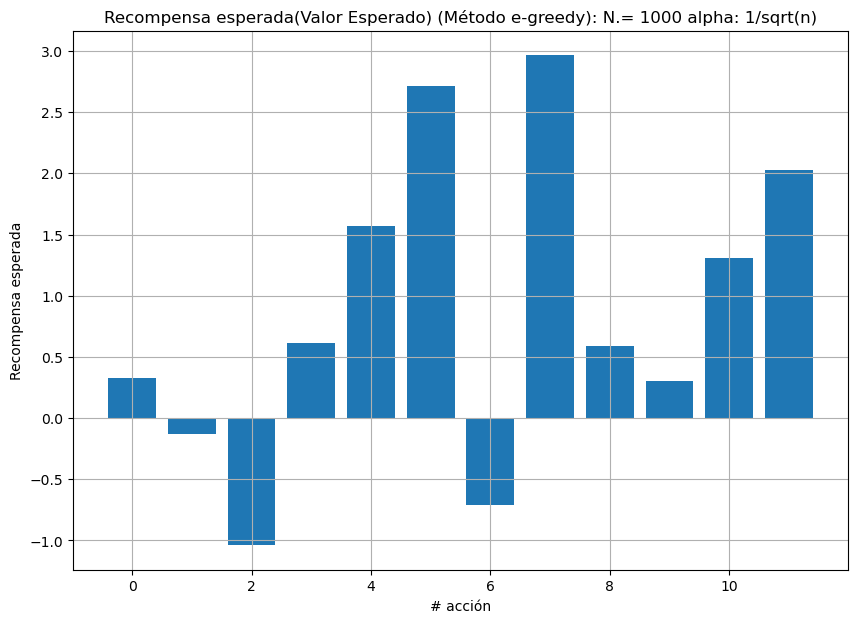

Recompensa esperada : [0.330914704246395, -0.1336615194328299, -1.0385910722130807, 0.614807753674781, 1.5736306875712318, 2.7122539892653648, -0.7118892075742286, 2.9651923987067317, 0.5884033641078762, 0.3027047709613924, 1.3071181695729923, 2.025190911937852]


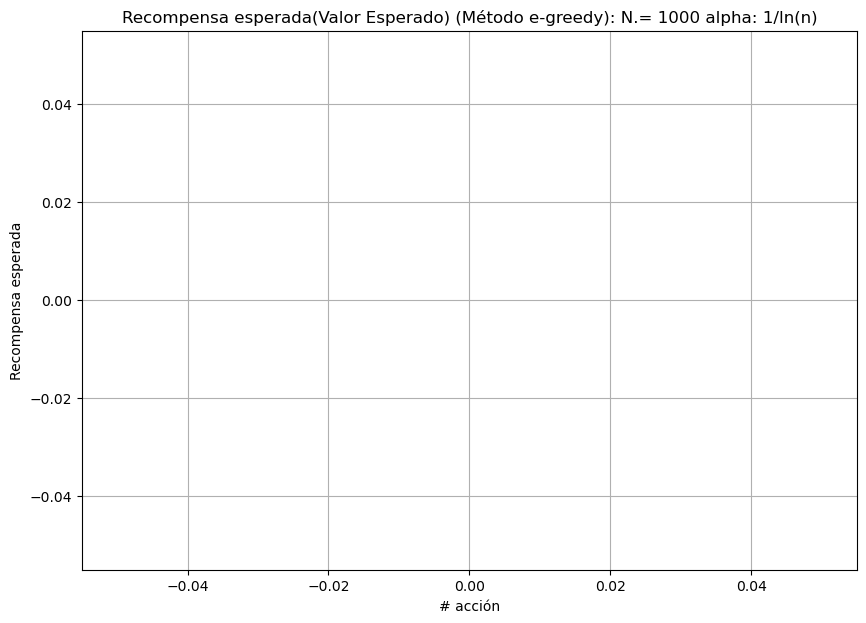

Recompensa esperada : [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]


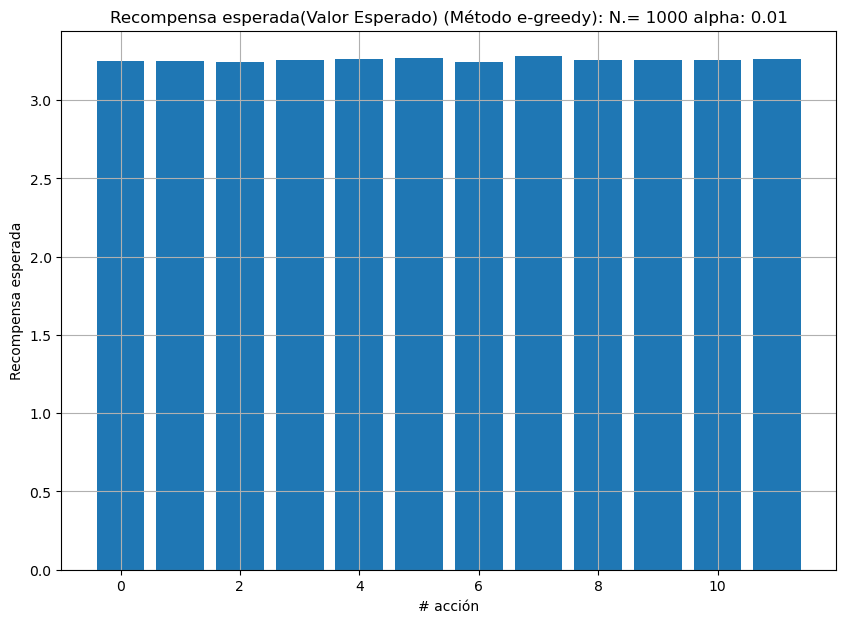

Recompensa esperada : [3.254031536209842, 3.2504896404416503, 3.2438434113454546, 3.2562002865393653, 3.2619566647679585, 3.2723697676670516, 3.245462029371031, 3.280303409490643, 3.2551702339435375, 3.2541320754917784, 3.2601202860563134, 3.264510404504364]


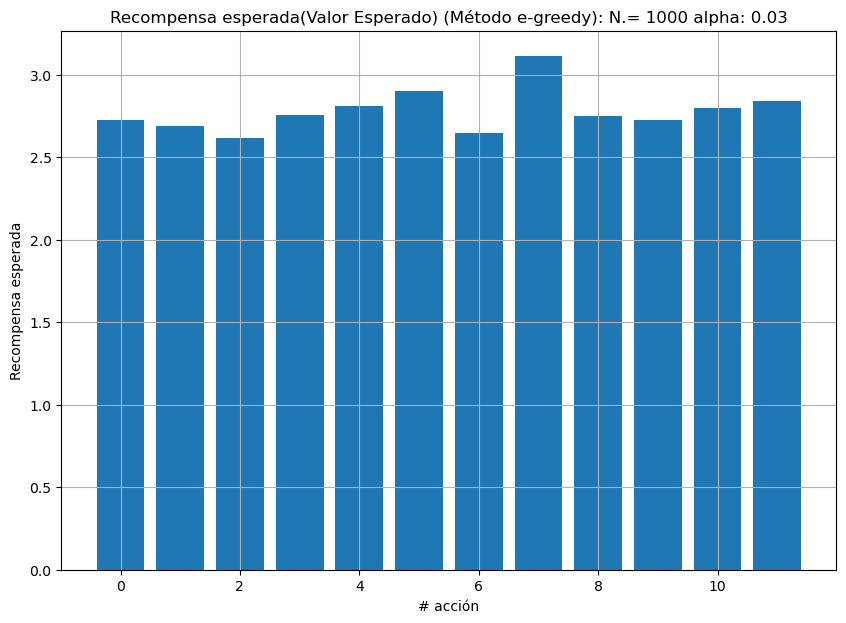

Recompensa esperada : [2.7284764965494035, 2.689929973357907, 2.6170475361735317, 2.755334021605817, 2.813705992737043, 2.9012772570524854, 2.647834848401096, 3.1119907529437674, 2.7528942238552556, 2.729212054609726, 2.7986841759696333, 2.842850289357167]


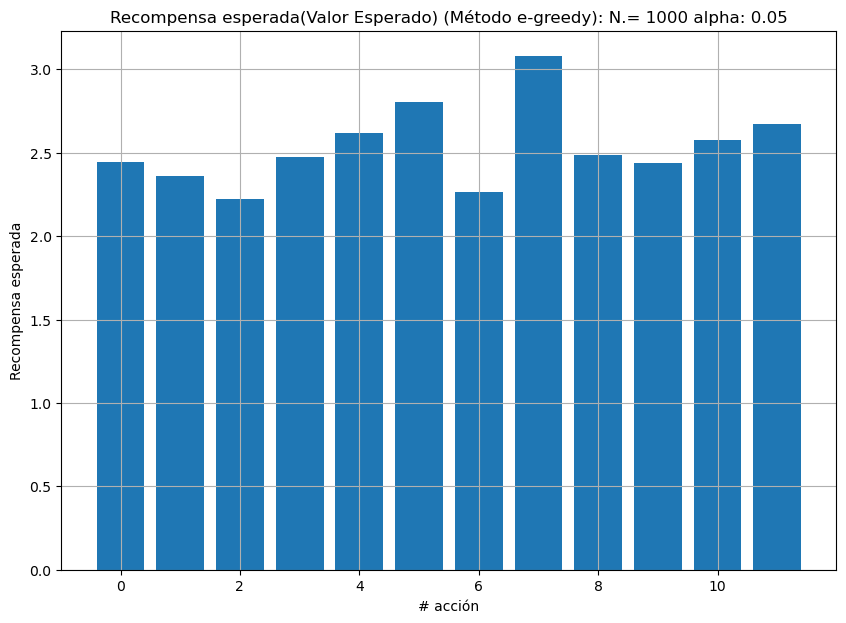

Recompensa esperada : [2.4470028711316623, 2.3621071204841813, 2.2219057303364638, 2.4755332884419823, 2.6173813777163724, 2.804034789519468, 2.262559865566007, 3.077604765210306, 2.4879962718291946, 2.4395848408740624, 2.5793149836400437, 2.672919917650862]


In [97]:
# Resultados: Recompensa promedio ponderada y Porcentaje de acciones óptimas 
N=1000 # numero de experimentos
n=1000 # time-step/iteraciones
actions = np.arange(0,12,1) # numero de bandits/acciones
env=5 # ambiente/escenario
eps=0.05
v0_egreedy = 5

alpha_n = np.linspace(0.01, 0.05, num=3)

retornos_recompensa_prom_egreedy = recompensa_promedio_ponderada2(N,n,actions,env,eps,v0_egreedy,alpha_n)
porcentaje_accion_opt_ponderado_greedy  = porcentaje_accion_opt_ponderado2(N,n,actions,env,eps,v0_egreedy,alpha_n)
recompensa_esperada = recompensa_esperada2(N,n,actions,env,eps,v0_egreedy,alpha_n)


# Conclusiones

Como se puede observar en las Figuras anteriores, las tasas de aprendizajes altas para el escenario run_env_5 de alta frecuencia con cambios relativamente mayores sobre la media $\mu$ de la distribución generan mayor retorno promedio con un valor de retorno 2.8 con una tasa de aprendizaje variable (método de promedio de muestra) se obtiene el mayor retorno a lo largo del tiempo donde la curva de retorno con $\alpha=1/\sqrt(N_t(a_i)))$ está siempre por encima de las otras curvas, sin embargo el estimado del valor esperado de la recompensa (recompensa esperada) no es congruente con el retorno obtenido por el algoritmo, es decir la tasa de aprendizaje variable ('sample-average case') obtiene un mayor retorno de la acción y escoge la acción óptima correctamente, pero no estima correctamente el valor esperado (recompensa esperada) de la distribución de las acciones en el problema de n-bandit, ya que no logra asegurar una estimación del valor esperado de la recompensa debido a la naturaleza no estacionaria de las distrubuciones de las acciones, las cuales están cambiando en función de t.

 Con base en los anteriores resultados y debido a la naturaleza no estacionaria en las distribuciones de los n-bandits, se sugiere la escogencia de una tasa de aprendizaje constante pequeña que explore y aprenda en detalle las variaciones en la distribución a lo largo del horizonte temporal. Por otro lado, para el caso no estacionario las 2 condiciones de convergencia ya no se satisfacen, y por ende se sugiere iterar sobre tasas de aprendizaje constantes pequeñas para poder explorar más minusciosamente las variaciones en la distribución y aprender de manera conservadora el problema de RL definido para una distribución no estacionaria.

A partir de estos resultados, junto con los resultados presentados en la literatura por los autores Sutton y Barto de las 2 condiciones de convergencia en el caso no estacionario, entonces se argumenta la selección de esta tasa de aprendizaje constante (ej: $\alpha_i= 0.05$)  para el escenario run_env_5 de alta frecuencia con mayor variación relativa de la media $\mu$.